In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

# import packages and set up style sheet
import numpy as np, numpy.ma as ma, datetime as dt, matplotlib.colors as pltcolors, matplotlib, pickle
from matplotlib import patches
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(3)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.42:39872 Dashboard: http://10.148.0.42:8787/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


___________
# Read data

In [18]:
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'

In [69]:
Theta = np.fromfile(LLC_data_folder+"Theta/Theta_177x201x52.20121009T060000" , dtype='>f').reshape(52,201,177)
Theta = np.fromfile(LLC_data_folder+"U/U_177x201x52.20121009T060000" , dtype='>f').reshape(52,201,177)

LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)

In [70]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth.shape

(1, 52)

In [71]:
# turn mean-lat into xarray_DataArray
Theta = np.array(Theta)
Theta = xr.DataArray(Theta, dims=['depth','x','y'])
Theta = np.real(Theta).rename('Theta')

In [72]:
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['x','y'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [73]:
LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['x','y'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [74]:
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [75]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'tem': (['depth', 'lon','lat'], Theta)},
                 coords={'XC': (['lon','lat'], LLC_XC), 
                         'YC': (['lon','lat'], LLC_YC),
                         'depth': (['depth'], Depth)})
print(ds)
print('\n data size: %.1f MB' %(ds.nbytes / 1e6))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 177, lon: 201)
Coordinates:
    XC       (lon, lat) >f4 -18.03125 -18.010416 -17.989584 -17.96875 ...
    YC       (lon, lat) >f4 47.404716 47.404716 47.404716 47.404716 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
Dimensions without coordinates: lat, lon
Data variables:
    tem      (depth, lon, lat) >f4 -0.11314765 -0.13013707 -0.14111654 ...

 data size: 7.7 MB


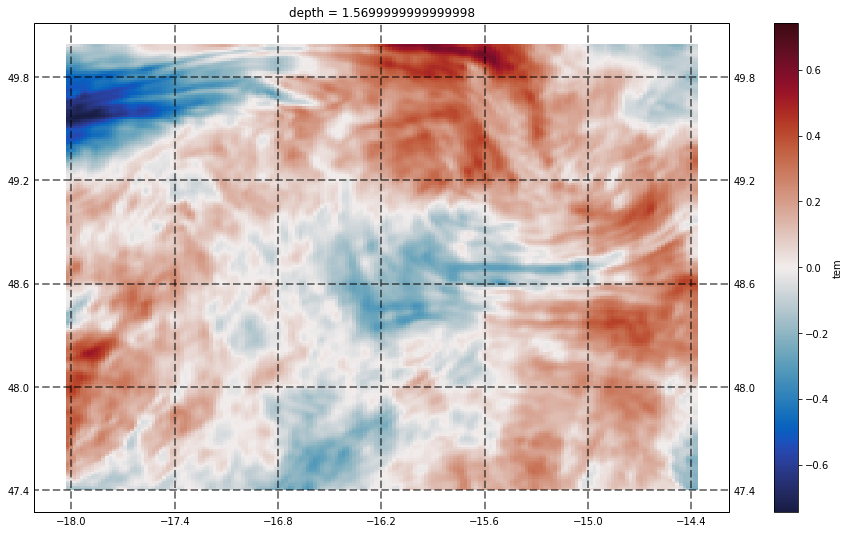

In [78]:
tem = ds['tem'].isel(depth=1) 

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
(tem).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), cmap=cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False



In [66]:
rd = dt.datetime(year=2012,month=1,day=1)
print(rd)
ddd = rd+dt.timedelta(days=117)
print(ddd)

2012-01-01 00:00:00
2012-04-27 00:00:00


In [56]:
t = np.fromfile(LLC_data_folder+"Theta/Theta_177x201x52.%04d%02d%02dT%02d0000" % (ddd.year,ddd.month,ddd.day,ddd.hour), dtype='>f').reshape(52,201,177)


FileNotFoundError: [Errno 2] No such file or directory: '/home1/datawork/xyu/OSMOSIS_llc4320/Theta/Theta_177x201x52.*'

In [80]:
cluster.scheduler.close()

<Future finished result=None>

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


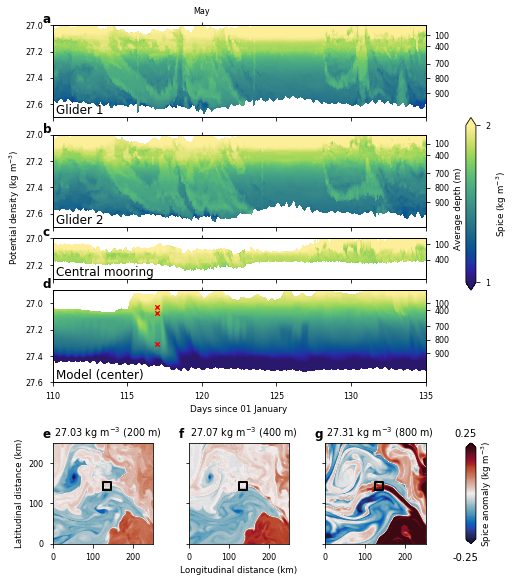

In [203]:
fig = plt.figure(figsize=(7,8))
ax1 = fig.add_axes([.1,.81,.74,.16])
ax2 = fig.add_axes([.1,.62,.74,.16])
ax3 = fig.add_axes([.1,.53,.74,.07])
ax4 = fig.add_axes([.1,.35,.74,.16])
ax5 = fig.add_axes([.1,.07,.20,.175])
ax6 = fig.add_axes([.37,.07,.20,.175])
ax7 = fig.add_axes([.64,.07,.20,.175])
cax1 = fig.add_axes([.92,.51,.02,.3])
cax2 = fig.add_axes([.92,.07,.02,.175])
plt.figtext(.92,.255,'0.25',ha='center')
plt.figtext(.92,.04,'-0.25',ha='center')

ax1.contourf(t1,pd1,sp1,levels=np.linspace(1,2.,100),cmap=cmocean.cm.haline,extend='both')
ax2.contourf(t2,pd2,sp2,levels=np.linspace(1,2.,100),cmap=cmocean.cm.haline,extend='both')
ax3.contourf(np.tile(mr_t,[len(mr_z),1]),pd_mr,sp_mr,levels=np.linspace(1,2.,100),cmap=cmocean.cm.haline,extend='both')
im1 = ax4.contourf(np.tile(nc.variables['time'][:],[len(llc_z),1]),nc.variables['sigma'][:].T,nc.variables['spice'][:].T,levels=np.linspace(1,2.,100),cmap=cmocean.cm.haline,extend='both')
ax4.scatter([117,117,117],np.array(pdens_slices),marker='x',s=20,color='r')
ax5.contourf(X[0],Y[0],sp_slice[0]-np.mean(sp_slice[0]),levels=np.linspace(-.25,.25,100),cmap=cmocean.cm.balance,extend='both');
ax6.contourf(X[0],Y[0],sp_slice[1]-np.mean(sp_slice[1]),levels=np.linspace(-.25,.25,100),cmap=cmocean.cm.balance,extend='both');
im2 = ax7.contourf(X[0],Y[0],sp_slice[2]-np.mean(sp_slice[2]),levels=np.linspace(-.25,.25,100),cmap=cmocean.cm.balance,extend='both');
ax5.plot(OSMOSIS_x[[0,0,1,1,0]],OSMOSIS_y[[0,1,1,0,0]],'k',lw=2)
ax6.plot(OSMOSIS_x[[0,0,1,1,0]],OSMOSIS_y[[0,1,1,0,0]],'k',lw=2)
ax7.plot(OSMOSIS_x[[0,0,1,1,0]],OSMOSIS_y[[0,1,1,0,0]],'k',lw=2)

XLIM = [110,135]
ax1.set_ylim([27.7,27.0]); ax2.set_ylim([27.7,27.0]); ax3.set_ylim([27.3,27.0]); ax4.set_ylim([27.6,26.9])
ax1.set_xlim(XLIM); ax2.set_xlim(XLIM); ax3.set_xlim(XLIM); ax4.set_xlim(XLIM)
ax5.set_xlim([0,250]); ax6.set_xlim([0,250]); ax7.set_xlim([0,250])
ax5.set_ylim([0,250]); ax6.set_ylim([0,250]); ax7.set_ylim([0,250])
ax5.set_yticks(np.arange(0,250,100)); ax6.set_yticks(np.arange(0,250,100)); ax7.set_yticks(np.arange(0,250,100));
ax5.set_xticks(np.arange(0,250,100)); ax6.set_xticks(np.arange(0,250,100)); ax7.set_xticks(np.arange(0,250,100));
ax1.set_xticklabels([]); ax2.set_xticklabels([]); ax3.set_xticklabels([]); ax6.set_yticklabels([]); ax7.set_yticklabels([]);
ax2.set_ylabel('Potential density (kg m$^{-3}$)                    '); ax4.set_xlabel('Days since 01 January');
ax5.set_ylabel('Latitudinal distance (km)');
ax6.set_xlabel('Longitudinal distance (km)')
ax5.set_title('   %.2f kg m$^{-3}$ (200 m)'%(pdens_slices[0]))
ax6.set_title('   %.2f kg m$^{-3}$ (400 m)'%(pdens_slices[1]))
ax7.set_title('   %.2f kg m$^{-3}$ (800 m)'%(pdens_slices[2]))

plt.colorbar(im1,cax=cax1,label='Spice (kg m$^{-3}$)',ticks=[1,2,3])
plt.colorbar(im2,cax=cax2,label='Spice anomaly (kg m$^{-3}$)',ticks=[])

ax1b = ax1.twiny(); 
ax1b.set_xticks(months_time)
ax1b.set_xlim(XLIM);
ax1b.set_xticklabels(months_labels_long);
ax2b = ax2.twiny(); 
ax2b.set_xticks(months_time)
ax2b.set_xlim(XLIM);
ax2b.set_xticklabels([]);
ax3b = ax3.twiny(); 
ax3b.set_xticks(months_time)
ax3b.set_xlim(XLIM);
ax3b.set_xticklabels([]);
ax4b = ax4.twiny(); 
ax4b.set_xticks(months_time)
ax4b.set_xlim(XLIM);
ax4b.set_xticklabels([]);

# add second y-labels for average depth
ax1c = ax1.twinx(); 
zzz = [100,400,700,800,900]
ax1c.set_yticks(np.interp(zzz,zzz_gl1,pp))
ax1c.set_yticklabels(zzz)
ax1c.set_ylim(ax1.get_ylim())
ax2c = ax2.twinx();
zzz = [100,400,700,800,900]
ax2c.set_yticks(np.interp(zzz,zzz_gl2,pp))
ax2c.set_yticklabels(zzz)
ax2c.set_ylim(ax2.get_ylim())
ax3c = ax3.twinx();
zzz = [100,400]
ax3c.set_yticks(np.interp(zzz,zzz_moor,pp))
ax3c.set_yticklabels(zzz)
ax3c.set_ylim(ax3.get_ylim())
ax4c = ax4.twinx();
zzz = [100,400,700,800,900]
ax4c.set_yticks(np.interp(zzz,zzz_llc,pp))
ax4c.set_yticklabels(zzz)
ax4c.set_ylim(ax4.get_ylim())

ax2c.set_ylabel('Average depth (m)                    ');

# add panel "titles"
ax1.annotate('Glider 1', xy=(0,0),xycoords=ax1.transAxes,color='k',size=fontsize,xytext=(3,3), textcoords="offset points")
ax2.annotate('Glider 2', xy=(0,0),xycoords=ax2.transAxes,color='k',size=fontsize,xytext=(3,3), textcoords="offset points")
ax3.annotate('Central mooring', xy=(0,0),xycoords=ax3.transAxes,color='k',size=fontsize,xytext=(3,3), textcoords="offset points")
ax4.annotate('Model (center)', xy=(0,0),xycoords=ax4.transAxes,color='k',size=fontsize,xytext=(3,3), textcoords="offset points")


# add panel labels
ax1.annotate('a', xy=(0,1),xycoords=ax1.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,2), textcoords="offset points")
ax2.annotate('b', xy=(0,1),xycoords=ax2.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,2), textcoords="offset points")
ax3.annotate('c', xy=(0,1),xycoords=ax3.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,2), textcoords="offset points")
ax4.annotate('d', xy=(0,1),xycoords=ax4.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,2), textcoords="offset points")
ax5.annotate('e', xy=(0,1),xycoords=ax5.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,5), textcoords="offset points")
ax6.annotate('f', xy=(0,1),xycoords=ax6.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,5), textcoords="offset points")
ax7.annotate('g', xy=(0,1),xycoords=ax7.transAxes,color='k',weight='bold',size=fontsize,xytext=(-10,5), textcoords="offset points")

plt.savefig('Timeseries',dpi=300)

# Figure 4: Spectra

In [15]:
# get data to calculate frequency spectra from model

num_files = dd.days*24 # one file per hour
print(num_files)
LLC_time = np.arange((sd-rd).days,(ed-rd).days,1/24)

depths = [200,800]
depth_indices = [np.argmin(np.abs(llc_z-dep)) for dep in depths] # find indices where model depth is closest to target depths
z_dep = llc_z[depth_indices]

LLC_U = [np.memmap('/Users/Zach/LLC_U_%03d.dat' % z_dep[i], dtype='>f', mode='r', shape=(201,177,num_files),order='C') for i in range(len(depths))];
LLC_V = [np.memmap('/Users/Zach/LLC_V_%03d.dat' % z_dep[i], dtype='>f', mode='r', shape=(201,177,num_files),order='C') for i in range(len(depths))];
LLC_W = [np.memmap('/Users/Zach/LLC_W_%03d.dat' % z_dep[i], dtype='>f', mode='r', shape=(201,177,num_files),order='C') for i in range(len(depths))];
LLC_Theta = [np.memmap('/Users/Zach/LLC_Theta_%03d.dat' % z_dep[i], dtype='>f', mode='r', shape=(201,177,num_files),order='C') for i in range(len(depths))];
LLC_Salt = [np.memmap('/Users/Zach/LLC_Salt_%03d.dat' % z_dep[i], dtype='>f', mode='r', shape=(201,177,num_files),order='C') for i in range(len(depths))];

LLC_lat = np.fromfile(LLC_data_folder+"YC_177x201", dtype='>f').reshape(201,177)
LLC_lon = np.fromfile(LLC_data_folder+"XC_177x201", dtype='>f').reshape(201,177)



8784


In [16]:
# frequency spectra
# split into 4 4-week segments, and use the 100 values closest to the OSMOSIS region
N = 28*24
num_segments = int(len(LLC_time)/N)
lonindex = np.argmin(np.abs(LLC_lat[:,0]-OSMOSIS_LAT))
latindex = np.argmin(np.abs(LLC_lon[0,:]-OSMOSIS_LON))
vals = [np.arange(0,len(LLC_time))[i*N:(i+1)*N] for i in range(num_segments)]
lonindices = np.arange(lonindex-5,lonindex+5); latindices = np.arange(latindex-5,latindex+5);
d = 1/24*86400 # time resolution in seconds
om = np.arange(-N/2,N/2)/N/d #omega
dom = om[1]-om[0]

In [17]:
def buoyancy_llc(Salt,Theta,depth):
    CT = gsw.CT_from_pt(Salt,Theta)
    sigma = gsw.density.sigma0(Salt,CT)
    if np.nanmean(sigma)<500:
        sigma += 1000
    return g*(1-sigma/rho_0)

In [18]:
Hanning_filter = np.tile(Hanning_window_1D(N).reshape(1,1,-1),[len(depths),num_segments*10*10,1])
# make datasets
UU = np.concatenate([[LLC_U[i][latindices][:,lonindices][:,:,vals[j]] for j in range(num_segments)] for i in range(len(depths))])
UU = UU.reshape(len(depths),num_segments*10*10,N)
UU -= np.tile(np.mean(UU,axis=(1,2))[:,np.newaxis,np.newaxis],[1,num_segments*10*10,N])
VV = np.concatenate([[LLC_V[i][latindices][:,lonindices][:,:,vals[j]] for j in range(num_segments)] for i in range(len(depths))])
VV = VV.reshape(len(depths),num_segments*10*10,N)
VV -= np.tile(np.mean(VV,axis=(1,2))[:,np.newaxis,np.newaxis],[1,num_segments*10*10,N])
bb = np.concatenate([[buoyancy_llc(LLC_Salt[i][latindices][:,lonindices][:,:,vals[j]],LLC_Theta[i][latindices][:,lonindices][:,:,vals[j]],z_dep[i]) for j in range(num_segments)] for i in range(len(depths))])
bb = bb.reshape(len(depths),num_segments*10*10,N)
bb -= np.tile(np.mean(bb,axis=(1,2))[:,np.newaxis,np.newaxis],[1,num_segments*10*10,N])
ss = np.concatenate([[spice(LLC_Salt[i][latindices][:,lonindices][:,:,vals[j]],LLC_Theta[i][latindices][:,lonindices][:,:,vals[j]],z_dep[i]) for j in range(num_segments)] for i in range(len(depths))])
ss = ss.reshape(len(depths),num_segments*10*10,N)
ss -= np.tile(np.mean(ss,axis=(1,2))[:,np.newaxis,np.newaxis],[1,num_segments*10*10,N])


In [19]:
F_u = np.fft.fft(UU*Hanning_filter,axis=-1)
F_v = np.fft.fft(VV*Hanning_filter,axis=-1)
F_b = np.fft.fft(bb*Hanning_filter,axis=-1)
F_sp = np.fft.fft(ss*Hanning_filter,axis=-1)

In [20]:
E_KE = np.real(np.fft.fftshift(F_u*np.conj(F_u) + F_v*np.conj(F_v),axes=2))/2/N**2/dom# note: imaginary component is 0
E_sp = np.real(np.fft.fftshift(F_sp*np.conj(F_sp),axes=2))/N**2/dom
E_PE = np.real(np.fft.fftshift(F_b*np.conj(F_b),axes=2))/2/np.tile(np.nanmean(llc_b_z,axis=0)[depth_indices][:,np.newaxis,np.newaxis],[1,num_segments*10*10,N])/N**2/dom

In [21]:
# get data to calculate frequency spectra from the moorings

matfile = [loadmat(fn) for fn in filename]
sal = [matfile[i]['salinity_ctd_%s_gridded'%loc_string[i]] for i in range(len(matfile))]
temp = [matfile[i]['temperature_ctd_%s_gridded'%loc_string[i]] for i in range(len(matfile))]
u = [matfile[i]['u_acm_%s_gridded'%loc_string[i]] for i in range(len(matfile))]
v = [matfile[i]['v_acm_%s_gridded'%loc_string[i]] for i in range(len(matfile))]

sp = [spice(sal[i],temp[i],np.tile(mr_z[:,np.newaxis],[1,sal[i].shape[1]])) for i in range(len(sal))]
b = [buoyancy(sal[i],temp[i],np.tile(mr_z[:,np.newaxis],[1,sal[i].shape[1]])) for i in range(len(sal))]

depth_index = np.argmin(np.abs(mr_z-depths[0]))

In [22]:
N_moor = 28*24*6; # one measurement every 10 minutes (1/6 hour) for 28 days
d = 600 # time resolution in seconds
om_moor = np.arange(-N_moor/2,N_moor/2)/N_moor/d #omega
dom = om_moor[1]-om_moor[0]

In [23]:
# get array of all of the u,v,b,spice values 
ss = np.concatenate([[sp[i][depth_index][k*N_moor:(k+1)*N_moor] for k in range(num_segments)] for i in range(len(sp))]).reshape(len(sp)*num_segments,N_moor)
bb = np.concatenate([[b[i][depth_index][k*N_moor:(k+1)*N_moor] for k in range(num_segments)] for i in range(len(sp))]).reshape(len(sp)*num_segments,N_moor)
UU = np.concatenate([[u[i][depth_index][k*N_moor:(k+1)*N_moor] for k in range(num_segments)] for i in range(len(sp))]).reshape(len(sp)*num_segments,N_moor)
VV = np.concatenate([[v[i][depth_index][k*N_moor:(k+1)*N_moor] for k in range(num_segments)] for i in range(len(sp))]).reshape(len(sp)*num_segments,N_moor)


In [24]:
# delete any arrays with nans
arrays_with_nans = np.any(np.isnan(UU*VV*ss*bb),axis=(-1))
print(np.sum(~arrays_with_nans))
ss = ss[~arrays_with_nans]
bb = bb[~arrays_with_nans]
UU = UU[~arrays_with_nans]
VV = VV[~arrays_with_nans]

99


In [25]:
# zero-level offset
ss -= np.mean(ss)
bb -= np.mean(bb)
UU -= np.mean(UU)
VV -= np.mean(VV)

In [26]:
Hanning_filter = np.tile(Hanning_window_1D(N_moor).reshape(1,-1),[np.sum(~arrays_with_nans),1])
F_u = np.fft.fft(UU*Hanning_filter,axis=-1)
F_v = np.fft.fft(VV*Hanning_filter,axis=-1)
F_b = np.fft.fft(bb*Hanning_filter,axis=-1)
F_sp = np.fft.fft(ss*Hanning_filter,axis=-1)

In [29]:
E_KE_moor = np.real(np.fft.fftshift(F_u*np.conj(F_u) + F_v*np.conj(F_v)))/2/N_moor**2/dom# note: imaginary component is 0
E_sp_moor = np.real(np.fft.fftshift(F_sp*np.conj(F_sp)))/N_moor**2/dom
E_PE_moor = np.real(np.fft.fftshift(F_b*np.conj(F_b)))/2/np.nanmean(mr_b_z[:,depth_index])/N_moor**2/dom

In [30]:
M2 = 1/(12.42*60*60)

In [44]:
n0*b0

6.76

In [47]:
k = np.logspace(-9,-3,500) # in cpm
omega = np.logspace(-4,-2,1e3) # in cps
E = E_kw(k,omega,sw.f(OSMOSIS_LAT),np.sqrt(np.nanmean(mr_b_z[:,depth_index])))
Zsq = ((omega**2-sw.f(OSMOSIS_LAT)**2)/np.sqrt(np.nanmean(mr_b_z[:,depth_index]))/omega**2)
GM_PE_om = np.trapz(E.T*Zsq,x=k,axis=0)*np.sqrt(np.nanmean(mr_b_z[:,depth_index]))**2/2*b0**2*n0
#GM_PE_om = b0**2*n0*np.sqrt(np.nanmean(mr_b_z[:,depth_index]))*E0*B(omega,f,np.sqrt(np.nanmean(mr_b_z[:,depth_index])))
GM_KE_om = np.trapz((((omega**2+sw.f(OSMOSIS_LAT)**2)/omega**2)*E_kw(k,omega,sw.f(OSMOSIS_LAT),np.sqrt(np.nanmean(mr_b_z[:,depth_index]))).T),x=k,axis=0)*b0**2*n0*np.sqrt(np.nanmean(mr_b_z[:,depth_index]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


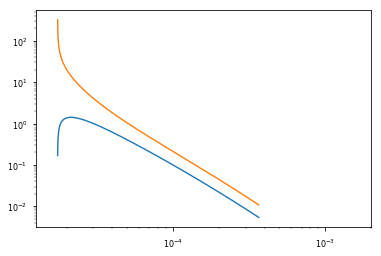

In [48]:
plt.loglog(omega/2/np.pi,GM_PE_om)
plt.loglog(omega/2/np.pi,GM_KE_om)

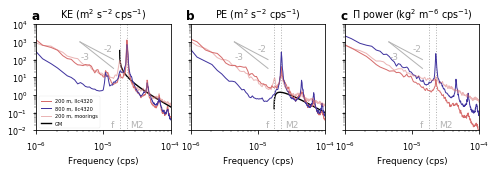

In [49]:
cmap = cmocean.cm.thermal_r
colors = [cmap(.4),cmap(.8)]

fig,ax = plt.subplots(1,3,figsize=(7,2.5))

for i in [0,1]:
    ax[2].loglog(om,np.mean(E_sp[i],axis=0),color=colors[i],lw=1)
    ax[1].loglog(om,np.mean(E_PE[i],axis=0),color=colors[i],lw=1)
    ax[0].loglog(om,np.mean(E_KE[i],axis=0),color=colors[i],lw=1)
ax[2].loglog(om_moor,np.mean(E_sp_moor,axis=0),color=colors[0],alpha=0.5,lw=1)
ax[1].loglog(om_moor,np.mean(E_PE_moor,axis=0),color=colors[0],alpha=0.5,lw=1)
ax[0].loglog(om_moor,np.mean(E_KE_moor,axis=0),color=colors[0],alpha=0.5,lw=1)

# plot GM
ax[0].loglog(omega/2/np.pi,GM_KE_om,color='k',zorder=0)
ax[1].loglog(omega/2/np.pi,GM_PE_om,color='k',zorder=0)

ax[0].legend(['200 m, llc4320','800 m, llc4320', '200 m, moorings','GM'],loc='lower left',fontsize=5)

for a in ax:
    a.set_ylim([1e-2,1e4]);
    a.set_xlim([1e-6,1e-4])
    a.set_xlabel('Frequency (cps)')
    a.plot(10**np.array([-5.35,-4.85]),10**np.array([3.,1.5]),color='0.7',zorder=0,lw=1)
    a.plot(10**np.array([-5.35,-4.85]),10**np.array([3.,2.]),color='0.7',zorder=0,lw=1)
    a.plot([f/2/np.pi,f/2/np.pi],[1e4,1e-2],color='0.7',zorder=0,ls=':',lw=1)
    a.plot([M2,M2],[1e4,1e-2],color='0.7',zorder=0,ls=':',lw=1)
    
    a.annotate('-3',xy=(4.5e-6,1e2),fontsize=9,color='0.7')
    a.annotate('-2',xy=(1e-5,3e2),fontsize=9,color='0.7')
    a.annotate('f',xy=(1.3e-5,1.5e-2),fontsize=9,color='0.7')
    a.annotate('M2',xy=(2.5e-5,1.5e-2),fontsize=9,color='0.7')
ax[2].set_title('$\Pi$ power (kg$^2$ m$^{-6}$ cps$^{-1}$)')
ax[1].set_title('PE (m$^2$ s$^{-2}$ cps$^{-1}$)')
ax[0].set_title('KE (m$^2$ s$^{-2}$ cps$^{-1}$)')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]);


# panel letters
ax[0].annotate('a', xy=(0,1),xycoords=ax[0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1].annotate('b', xy=(0,1),xycoords=ax[1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2].annotate('c', xy=(0,1),xycoords=ax[2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.tight_layout(w_pad=0)

plt.savefig('Spectra',dpi=300)

## Get Structure Functions

In [14]:
# make function to fit mooring data to a line (input distance, data, bin_edges)
def mooring_to_fit(dist,data,bin_edges,interp=False,output_n=False):
    if np.sum(~np.isnan(data))<=2:
        return np.nan*np.empty(len(bin_edges)-1)
    fit = np.array([np.nanmean(data[np_and(dist>bin_edges[i],dist<bin_edges[i+1])],axis=0) for i in range(len(bin_edges)-1)])
    if interp:
        bin_centers = bin_edges[0:-1]+np.diff(bin_edges)/2
        isnan = np.isnan(fit)
        fit[isnan] = np.interp(bin_centers[isnan],bin_centers[~isnan],fit[~isnan])
    if output_n:
        n = np.array([np.sum(np_and(dist>bin_edges[i],dist<bin_edges[i+1])) for i in range(len(bin_edges)-1)])
        return fit,n
    else:
        return fit

In [15]:
num_bins = 8
bin_edges = np.logspace(0,np.log10(20),num_bins+1)
bin_centers = bin_edges[0:-1]+np.diff(bin_edges)/2

num_bins_llc = 14
bin_edges_llc = np.logspace(0,np.log10(20)*2,num_bins_llc+3)[0:-2]
bin_centers_llc = bin_edges_llc[0:-1]+np.diff(bin_edges_llc)/2


In [16]:
gl_nc = Dataset('../Draft_1812/SFs_gliders.nc','r')
gl_nc_av = Dataset('../Draft_1812/SFs_gliders_ave.nc','r')
mr_nc = Dataset('../Draft_1812/SFs_mooring.nc','r')
llc_nc = Dataset('../Draft_1812/SFs_llc.nc','r')

In [17]:
gl_sf_z = gl_nc.variables['depth'][:]
mr_sf_z = mr_nc.variables['depth'][:]
llc_sf_z = llc_nc.variables['depth'][:]

mr_sf_d = mr_nc.variables['distance'][:]

In [18]:
gl_b_z_sfs = np.empty(shape=gl_nc.variables['n_timewindow'][:,:,0].shape)
for i in range(len(gl_nc.variables['time_window'])):
    inds = np.abs(gl_t-gl_nc.variables['time_window'][i])<30
    gl_b_z_sfs[i] = np.interp(gl_sf_z,gl_z_diff,np.nanmean(gl_b_z[inds],axis=0))
    
mr_b_z_sfs = interp1d(mr_z_diff,gaussian_filter1d(mr_b_z,30/2.355/np.mean(np.diff(mr_t)),axis=0),bounds_error=False,axis=1)(mr_z)
llc_b_z_sfs = interp1d(llc_z_diff,gaussian_filter1d(llc_b_z,30/2.355,axis=0),bounds_error=False,axis=1)(llc_z)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


(1000, 0)

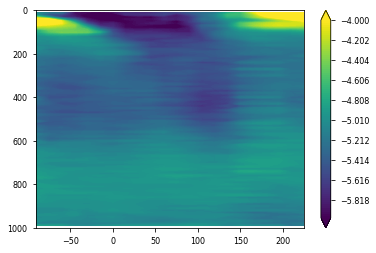

In [19]:
plt.contourf(gl_nc.variables['time_window'][:],gl_sf_z,np.log10(gl_b_z_sfs.T),levels=np.linspace(-6,-4,100),extend='both');
plt.colorbar()
plt.ylim([1000,0])

(1000, 0)

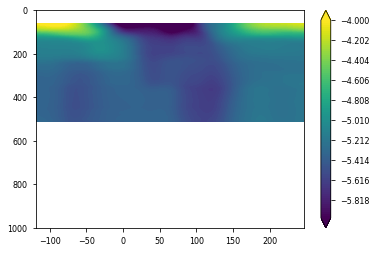

In [20]:
plt.contourf(mr_t,mr_z,np.log10(mr_b_z_sfs).T,levels=np.linspace(-6,-4,100),extend='both')
plt.colorbar()
plt.ylim([1000,0])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(1000, 0)

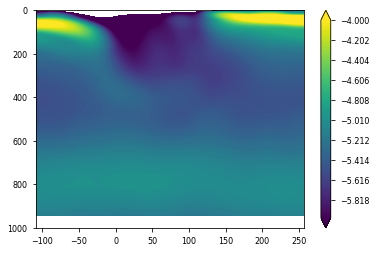

In [21]:
plt.contourf(llc_t,llc_z,np.log10(llc_b_z_sfs.T),levels=np.linspace(-6,-4,100),extend='both')
plt.colorbar()
plt.ylim([1000,0])

## Figure 5: SFs

In [26]:
gl_good_inds = np.concatenate((np.arange(0,4),np.arange(8,len(gl_nc.variables['time_window'][:]))))

In [68]:
omega = np.logspace(-2,1,300) *2*np.pi/3600 # convert from cph to rad/s
k = np.logspace(-3,0,1000) # in cpkm
s = np.logspace(0,2,100) # in km

Nsq = np.nanmean(mr_b_z[:,depth_index])
n = np.sqrt(Nsq)
f = sw.f(OSMOSIS_LAT)

GM_PE = F_PE_k(k/1e3,f,np.sqrt(Nsq))/1e3 # convert from m^2/s^2/cpm to m^2/s^2/cpkm
GM_KE = np.trapz((b0**2*n0*n*np.tile(((omega**2+f**2)/omega**2).reshape(-1,1),[1,k.size])*E_kw(k/1e3,omega,f,n)).T,omega)/1e3

GM_PE_SF = cycle_to_distance(GM_PE,k,s)
GM_KE_SF = cycle_to_distance(GM_KE,k,s)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


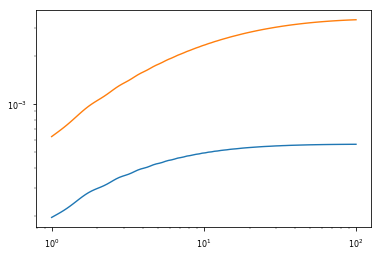

In [79]:
plt.loglog(s,GM_PE_SF)
plt.loglog(s,GM_KE_SF)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning

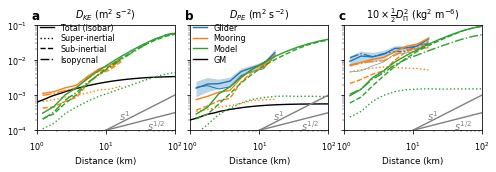

In [83]:
depth = 200;
fig,ax = plt.subplots(1,3,figsize=(7,2.5))

# plot glider SFs
depind = np.argmin(np.abs(gl_sf_z-depth))
#ax[0].plot([0],[0])
sf = np.nanmean(gl_nc.variables['D_2_b_timewindow'][gl_good_inds][:,depind].T/2/gl_b_z_sfs[gl_good_inds][:,depind],axis=-1).T
l1, = ax[1].plot(bin_centers,sf[:,1],color='C0')
ax[1].fill_between(bin_centers,sf[:,0],sf[:,2],alpha=0.3,color='C0')
sf = np.nanmean(gl_nc.variables['D_2_sp_timewindow'][gl_good_inds][:,depind],axis=0)/2
ax[2].plot(bin_centers,10*sf[:,1],color='C0')
ax[2].fill_between(bin_centers,10*sf[:,0],10*sf[:,2],alpha=0.3,color='C0')
# after averaging vertically
sf = np.nanmean(gl_nc_av.variables['D_2_b_timewindow'][gl_good_inds][:,depind].T/2/gl_b_z_sfs[gl_good_inds][:,depind],axis=-1).T
ax[1].plot(bin_centers,sf,color='C0',lw=1)
sf = np.nanmean(gl_nc_av.variables['D_2_sp_timewindow'][gl_good_inds][:,depind],axis=0)/2
ax[2].plot(bin_centers,10*sf,color='C0',lw=0.5)
depind = np.nanargmin(np.abs(np.nanmean(gl_nc.variables['z_isopycnal'][gl_good_inds],axis=0)-depth))
sf = np.nanmean(gl_nc.variables['D_2_sp_isopycnal_timewindow'][gl_good_inds][:,depind],axis=0)/2
ax[2].plot(bin_centers,10*sf[:,1],color='C0',ls='-.')

                   
# plot mooring SFs
depind = np.argmin(np.abs(mr_sf_z-depth))
sf = mooring_to_fit(mr_sf_d,np.nanmean((mr_nc.variables['d_u'][:,depind]**2+mr_nc.variables['d_v'][:,depind]**2)/2,axis=1),bin_edges,interp=True)
ax[0].plot(bin_centers,sf,color='C1')
moor_sub = np.array([np.nanmean(np.convolve(mr_nc.variables['d_u'][:,depind][i],np.ones(96)/96,'valid')**2 + np.convolve(mr_nc.variables['d_v'][:,depind][i],np.ones(96)/96,'valid')**2)  for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sub/2,bin_edges,interp=True)
ax[0].plot(bin_centers,sf,color='C1',ls='--')
moor_sup = np.array([np.nanmean((mr_nc.variables['d_u'][:,depind][i][47:-48]-np.convolve(mr_nc.variables['d_u'][:,depind][i],np.ones(96)/96,'valid'))**2 + (mr_nc.variables['d_v'][:,depind][i][47:-48]-np.convolve(mr_nc.variables['d_v'][:,depind][i],np.ones(96)/96,'valid'))**2) for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sup/2,bin_edges,interp=True)
ax[0].plot(bin_centers,sf,color='C1',ls=':')
sf = mooring_to_fit(mr_sf_d,np.nanmean(mr_nc.variables['d_b'][:,depind]**2/2/mr_b_z_sfs[:,depind],axis=1),bin_edges,interp=True)
l2, = ax[1].plot(bin_centers,sf,color='C1')
moor_sub = np.array([np.nanmean(np.convolve(mr_nc.variables['d_b'][:,depind][i],np.ones(96)/96,'valid')**2 /2/mr_b_z_sfs[48:-47,depind]) for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sub,bin_edges,interp=True)
ax[1].plot(bin_centers,sf,color='C1',ls='--')
moor_sup = np.array([np.nanmean((mr_nc.variables['d_b'][:,depind][i][47:-48]-np.convolve(mr_nc.variables['d_b'][:,depind][i],np.ones(96)/96,'valid'))**2 /2/mr_b_z_sfs[48:-47,depind]) for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sup,bin_edges,interp=True)
ax[1].plot(bin_centers,sf,color='C1',ls=':')
sf = mooring_to_fit(mr_sf_d,np.nanmean(mr_nc.variables['d_spice'][:,depind]**2,axis=1),bin_edges,interp=True)/2
ax[2].plot(bin_centers,10*sf,color='C1')
moor_sub = np.array([np.nanmean(np.convolve(mr_nc.variables['d_spice'][:,depind][i],np.ones(96)/96,'valid')**2) for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sub/2,bin_edges,interp=True)
ax[2].plot(bin_centers,10*sf,color='C1',ls='--')
moor_sup = np.array([np.nanmean((mr_nc.variables['d_spice'][:,depind][i][47:-48]-np.convolve(mr_nc.variables['d_spice'][:,depind][i],np.ones(96)/96,'valid'))**2) for i in range(36)])
sf = mooring_to_fit(mr_sf_d,moor_sup/2,bin_edges,interp=True)
ax[2].plot(bin_centers,10*sf,color='C1',ls=':')
depind = np.argmin(np.abs(np.nanmean(mr_nc.variables['z_isopycnal'][:],axis=1)-depth))
sf = mooring_to_fit(mr_sf_d,np.nanmean((mr_nc.variables['d_u_isopycnal'][:,depind]**2+mr_nc.variables['d_v_isopycnal'][:,depind]**2)/2,axis=1),bin_edges,interp=True)
ax[0].plot(bin_centers,sf,color='C1',ls='-.')
sf = mooring_to_fit(mr_sf_d,np.nanmean(mr_nc.variables['d_spice_isopycnal'][:,depind]**2,axis=1),bin_edges,interp=True)/2
ax[2].plot(bin_centers,10*sf,color='C1',ls='-.')

# plot model SFs
depind = np.argmin(np.abs(llc_sf_z-depth))
sf = np.nanmean(llc_nc.variables['D_2_u'][:,depind]+llc_nc.variables['D_2_v'][:,depind],axis=0)/2
ax[0].plot(bin_centers_llc,sf,color='C2')
u_sub,u_sup = pickle.load(open('../Draft_1811/llc_SF_fil_u.p','rb'))
v_sub,v_sup = pickle.load(open('../Draft_1811/llc_SF_fil_v.p','rb'))
ax[0].loglog(bin_centers_llc,np.nanmean(u_sub[:,depind]+v_sub[:,depind],axis=0)/2,color='C2',ls='--')
ax[0].loglog(bin_centers_llc,np.nanmean(u_sup[:,depind]+v_sup[:,depind],axis=0)/2,color='C2',ls=':')
sf = np.nanmean(llc_nc.variables['D_2_b'][:,depind].T/2/llc_b_z_sfs[:,depind],axis=1)
l3, = ax[1].plot(bin_centers_llc,sf,color='C2')
pd_sub,pd_sup = pickle.load(open('../Draft_1811/llc_SF_fil_pd.p','rb'))
b_sub = np.nanmean(pd_sub[0:24*365,depind].reshape(24,365,14),axis=0)*(g/rho_0)**2
b_sup = np.nanmean(pd_sup[0:24*365,depind].reshape(24,365,14),axis=0)*(g/rho_0)**2
ax[1].loglog(bin_centers_llc,np.nanmean(b_sub.T/2/llc_b_z_sfs[0:-1,depind],axis=1),color='C2',ls='--')
ax[1].loglog(bin_centers_llc,np.nanmean(b_sup.T/2/llc_b_z_sfs[0:-1,depind],axis=1),color='C2',ls=':')
sf = np.nanmean(llc_nc.variables['D_2_sp'][:,depind],axis=0)/2
ax[2].plot(bin_centers_llc,10*sf,color='C2')
sp_sub,sp_sup = pickle.load(open('../Draft_1811/llc_SF_fil_sp.p','rb'))
ax[2].loglog(bin_centers_llc,10*np.nanmean(sp_sub[:,depind],axis=0)/2,color='C2',ls='--')
ax[2].loglog(bin_centers_llc,10*np.nanmean(sp_sup[:,depind],axis=0)/2,color='C2',ls=':')
depind = np.nanargmin(np.abs(np.nanmean(llc_nc.variables['z_isopycnal'][:],axis=0)-depth))
sf = np.nanmean(llc_nc.variables['D_2_u_isopycnal'][:,depind]+llc_nc.variables['D_2_v_isopycnal'][:,depind],axis=0)/2
ax[0].plot(bin_centers_llc,sf,color='C2',ls='-.')
sf = np.nanmean(llc_nc.variables['D_2_sp_isopycnal'][:,depind],axis=0)/2
ax[2].plot(bin_centers_llc,10*sf,color='C2',ls='-.')

ax[0].loglog(s,GM_KE_SF,color='k',zorder=0)
ax[1].loglog(s,GM_PE_SF,color='k',zorder=0)

for a in ax:
    a.set_xscale('log');
    a.set_yscale('log')
    a.set_xlabel('Distance (km)')
    a.set_xlim([1,100])
    a.set_ylim([1e-4,1e-1])
    a.loglog([1e1,1e2],[1e-4,1e-3],color='0.5')
    a.loglog([1e1,1e3],[1e-4,1e-3],color='0.5')
    a.annotate('$s^1$',xy=(.6,.1),  xycoords=a.transAxes,color='0.5',size=10)
    a.annotate('$s^{1/2}$',xy=(.8,0.005),xycoords=a.transAxes,color='0.5',size=10)
    
ax[1].set_yticklabels([]); ax[2].set_yticklabels([])

ax[2].set_title(r'$10 \times \frac{1}{2}D_\Pi^2$ (kg$^2$ m$^{-6}$)');
ax[1].set_title('$D_{PE}$ (m$^2$ s$^{-2}$)');
ax[0].set_title('$D_{KE}$ (m$^2$ s$^{-2}$)');

l1, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='k',ls='-')
l2, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='k',ls='--')
l3, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='k',ls=':')
l4, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='k',ls='-.')
ax[0].legend([l1,l3,l2,l4],['Total (isobar)','Super-inertial','Sub-inertial','Isopycnal'],loc=(0,.6),frameon=False,labelspacing=0.2,handlelength=1.75)
l1, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='C0')
l2, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='C1')
l3, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='C2')
l4, = ax[0].loglog([1e-10,1e-10],[1e-10,1e-10],color='k')
ax[1].legend([l1,l2,l3,l4],['Glider','Mooring','Model','GM'],loc=(0,.6),frameon=False,labelspacing=0.2,handlelength=1.75)

plt.tight_layout(w_pad=0)

ax[0].annotate('a', xy=(0,1),xycoords=ax[0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1].annotate('b', xy=(0,1),xycoords=ax[1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2].annotate('c', xy=(0,1),xycoords=ax[2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('SF',dpi=300)

## Figure 6: Interpolation

In [487]:
i = 500;
profile = buoyancy(nc_SG_L2[0].variables['salinity'][i],nc_SG_L2[0].variables['pot_temperature'][i],gl_z)
#profile[0] = profile[1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [490]:
mooring_depths = np.array([30, 85, 133, 203, 273, 327, 490])
profile_depth_inds = np.array([np.argmin(np.abs(gl_z-dep)) for dep in mooring_depths])
profile_moor = np.interp(mr_z,mooring_depths,profile[profile_depth_inds])

In [492]:
LLC_thickness = loadmat(LLC_data_folder+"thk52.mat")['thk52'].ravel()
profile_LLC = np.array([np.nanmean(profile[np.abs(gl_z-llc_z[i])<=LLC_thickness[i]/2]) for i in range(len(llc_z))])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


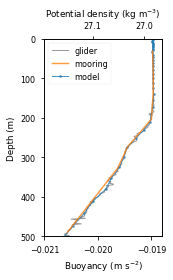

In [495]:
plt.figure(figsize=(2.5,4))
l1, = plt.plot(profile,gl_z,color='0.5',lw=1,alpha=0.8,zorder=-1)
notnan = ~np.isnan(profile_LLC)
l3, = plt.plot(profile_LLC[notnan],llc_z[notnan],alpha=0.8,marker='.',markersize=5,lw=1)
l2, = plt.plot(profile[profile_depth_inds],mooring_depths,alpha=0.8)
plt.ylim([500,0]); plt.xlim([-.021,-.0188]); plt.xticks(np.arange(-0.021,-0.0188,0.001))

plt.xlabel('Buoyancy (m s$^{-2}$)')
plt.ylabel('Depth (m)');
plt.legend([l1,l2,l3],['glider','mooring','model'],loc='upper left')
plt.twiny()
plt.xlim(rho_0-np.array([-.021,-.0188])*rho_0/g - 1000)
plt.xlabel('Potential density (kg m$^{-3}$)')
plt.tight_layout()
plt.savefig('data_comparison',dpi=300)

## Figure 7: SFs in grid

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShel

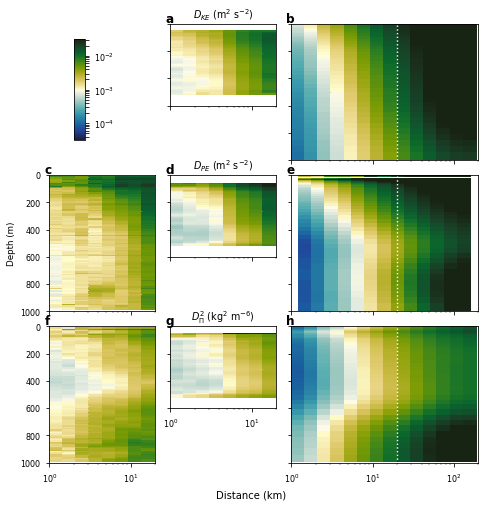

In [516]:
fig = plt.figure(figsize=(7,7))
h = .27; h2 = h*6/10; w1 = .21; w2 = w1*2.3/1.3; hh = 0.03; ww = 0.03;
ax = (fig.add_axes([.1,.95-h,w1,h]), fig.add_axes([.1+w1+ww,.95-h2,w1,h2]), fig.add_axes([.1+2*w1+ww*2,.95-h,w2,h]), \
      fig.add_axes([.1,.95-2*h-hh,w1,h]), fig.add_axes([.1+w1+ww,.95-h-h2-hh,w1,h2]), fig.add_axes([.1+2*w1+ww*2,.95-2*h-hh,w2,h]), \
      fig.add_axes([.1,.95-3*h-2*hh,w1,h]), fig.add_axes([.1+w1+ww,.95-2*h-h2-2*hh,w1,h2]), fig.add_axes([.1+2*w1+ww*2,.95-3*h-2*hh,w2,h]),)

sf = np.array([mooring_to_fit(mr_sf_d,np.nanmean(mr_nc.variables['d_u'][:,i,:]**2+mr_nc.variables['d_v'][:,i,:]**2,axis=1)/2,bin_edges,interp=True) for i in range(len(mr_z))])
ax[1].pcolormesh(bin_edges,mr_z,np.ma.masked_invalid(sf),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
im = ax[2].pcolormesh(bin_edges_llc,llc_z,np.ma.masked_invalid(np.nanmean(llc_nc.variables['D_2_u'][:]+llc_nc.variables['D_2_v'][:],axis=0))/2,norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
ax[3].pcolormesh(bin_edges,gl_sf_z, \
                 np.ma.masked_invalid(np.nanmean((gl_nc.variables['D_2_b_timewindow'][:,:,:,1].T/2/gl_b_z_sfs.T).T,axis=0)), \
                 norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
sf = np.array([mooring_to_fit(mr_sf_d,np.nanmean(mr_nc.variables['d_b'][:,i,:]**2/2/mr_b_z_sfs[:,i],axis=1),bin_edges,interp=True) for i in range(len(mr_z))])
ax[4].pcolormesh(bin_edges,mr_z,np.ma.masked_invalid(sf),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
ax[5].pcolormesh(bin_centers_llc,llc_z,np.ma.masked_invalid(np.nanmean((llc_nc.variables['D_2_b'][:].T/2/llc_b_z_sfs.T).T,axis=0)),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
ax[6].pcolormesh(bin_edges,gl_sf_z,np.ma.masked_invalid(np.nanmean(gl_nc.variables['D_2_sp_timewindow'][:,:,:,1]/2,axis=0)),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
sf = np.array([mooring_to_fit(mr_nc.variables['distance'][:],np.nanmean(mr_nc.variables['d_spice'][:,i,:]**2,axis=1)/2,bin_edges,interp=True) for i in range(len(mr_z))])
ax[7].pcolormesh(bin_edges,mr_z,np.ma.masked_invalid(sf),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
ax[8].pcolormesh(bin_edges_llc,llc_z,np.ma.masked_invalid(np.nanmean(llc_nc.variables['D_2_sp'][:],axis=0))/2,norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)

for a in ax:
    a.set_xscale('log'); a.set_ylim([1000,0])
for a in ax[0::3]:
    a.set_xlim([1,20]);
for a in ax[1::3]:
    a.set_xlim([1,20]);
    a.set_ylim([600,0])
    a.set_yticklabels([])
for a in ax[2::3]:
    a.set_xlim([1,200]);
    a.set_yticklabels([])
    a.plot([20,20],[1000,0],color='w',ls=':')
for a in ax[0:6]:
    a.set_xticklabels([])
ax[0].set_visible(False)

ax[7].set_title(r'$D_\Pi^2$ (kg$^2$ m$^{-6}$)')
ax[4].set_title('$D_{PE}$ (m$^2$ s$^{-2}$)')
ax[1].set_title('$D_{KE}$ (m$^2$ s$^{-2}$)')
ax[3].set_ylabel('Depth (m)');
plt.figtext(.5,.01,'Distance (km)',ha='center')

cax = fig.add_axes([.15,.72,.02,.2])
plt.colorbar(im,cax=cax)

# add panel labels
ax[1].annotate('a', xy=(0,1),xycoords=ax[1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[2].annotate('b', xy=(0,1),xycoords=ax[2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[3].annotate('c', xy=(0,1),xycoords=ax[3].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[4].annotate('d', xy=(0,1),xycoords=ax[4].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[5].annotate('e', xy=(0,1),xycoords=ax[5].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[6].annotate('f', xy=(0,1),xycoords=ax[6].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[7].annotate('g', xy=(0,1),xycoords=ax[7].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[8].annotate('h', xy=(0,1),xycoords=ax[8].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")

plt.savefig('SF_grid',dpi=300)

# Figure 8: Interpolation effect (grid)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


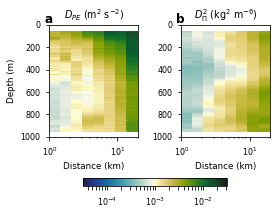

In [527]:
fig,ax = plt.subplots(1,2,figsize=(4,3))

im = ax[0].pcolormesh(bin_edges,gl_sf_z[5:-4], \
                 np.ma.masked_invalid(np.nanmean((gl_nc_av.variables['D_2_b_timewindow'][:,:,:].T/2/gl_b_z_sfs.T[5:-4]).T,axis=0)), \
                 norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)
ax[1].pcolormesh(bin_edges,gl_sf_z[5:-4],np.ma.masked_invalid(np.nanmean(gl_nc_av.variables['D_2_sp_timewindow'][:]/2,axis=0)),norm=pltcolors.LogNorm(vmin=10**-4.5, vmax=10**-1.5),cmap=cmocean.cm.delta)

for a in ax:
    a.set_xscale('log')
    a.set_xlim([1,20])
    a.set_xlabel('Distance (km)')
    a.set_ylim([1000,0])
ax[0].set_ylabel('Depth (m)');
ax[0].set_title('$D_{PE}$ (m$^2$ s$^{-2}$)')
ax[1].set_title('$D_\Pi^2$ (kg$^2$ m$^{-6}$)')

plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
cax = fig.add_axes([.3,.12,.5,.04])
plt.colorbar(im,cax=cax,orientation='horizontal')

# add panel labels
ax[0].annotate('a', xy=(0,1),xycoords=ax[0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")
ax[1].annotate('b', xy=(0,1),xycoords=ax[1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,2), textcoords="offset points")

plt.savefig('SF_grid_gl_av',dpi=300)

## Make fits

In [19]:
def linfit(x,a,b):
    return a*x+b

In [20]:
DISTANCE = 20;
def fit_to_slope(distance,data,weights=None):
    if weights is None:
        weights = np.ones(shape=data.shape)
    num = data.shape[0]
    slopes = np.empty(num).astype('float64'); slopes_error = np.empty(num)
    offsets = np.empty(num).astype('float64'); offsets_error = np.empty(num)
    for i in range(num):
        good_inds = np_and(data[i]>0,np_and(~np.isnan(data*weights)[i],~np.isinf(data*weights)[i]))
        if np.sum(good_inds)<2:
            slopes[i] = np.nan; slopes_error[i] = np.nan; offsets[i] = np.nan; offsets_error[i] = np.nan;
        else:
            coeffs,covar = curve_fit(linfit,(np.log10(distance[good_inds])-np.log10(DISTANCE)).astype('float64'),np.log10(data[i][good_inds]).astype('float64'),sigma=1/weights[i][good_inds].astype('float64'))
            slopes[i] = coeffs[0]; slopes_error[i] = np.sqrt(covar[0,0]);
            offsets[i] = 10**coeffs[1]; offsets_error[i] = 10**np.sqrt(covar[1,1]);
    return slopes,slopes_error,offsets,offsets_error

In [21]:
gl_fit_inds = np.arange(3,len(bin_centers))
mr_fit_inds = np.argsort(mr_sf_d)[8::]
llc_fit_inds = gl_fit_inds.copy()
print(np.round(bin_centers[gl_fit_inds],1))
print(np.round(np.sort(mr_sf_d[mr_fit_inds]),1))
print(np.round(bin_centers_llc[llc_fit_inds],1))

[ 3.8  5.5  8.  11.6 16.9]
[ 2.9  3.2  7.5  7.6  7.9  8.4  9.1  9.2  9.3  9.4  9.4  9.5  9.5  9.5
  9.5  9.6  9.6  9.8 10.5 10.7 11.1 11.2 13.1 13.2 13.3 13.3 18.6 18.8]
[ 3.8  5.5  8.  11.6 16.9]


In [27]:
# make yearly fits

# gliders
sf = np.nanmean((gl_nc.variables['D_2_b_timewindow'][gl_good_inds][:,:,:,1].T/2/gl_b_z_sfs[gl_good_inds].T).T,axis=0)
w = np.mean(gl_nc.variables['n_timewindow'][gl_good_inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_b_timewindow'][gl_good_inds][...,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_PE_fit_yr = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])
sf = np.nanmean(gl_nc.variables['D_2_sp_timewindow'][gl_good_inds][...,1],axis=0)/2
w = np.mean(gl_nc.variables['n_timewindow'][gl_good_inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_sp_timewindow'][gl_good_inds][...,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_sp_fit_yr = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])

# gliders (averaged)
sf = np.nanmean((gl_nc_av.variables['D_2_b_timewindow'][gl_good_inds][:,:,:].T/2/gl_b_z_sfs[gl_good_inds][:,5:-4].T).T,axis=0)
gl_av_PE_fit_yr = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])
sf = np.nanmean(gl_nc_av.variables['D_2_sp_timewindow'][gl_good_inds][:],axis=0)/2
gl_av_sp_fit_yr = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])

# mooring
sf = np.nanmean(mr_nc.variables['d_u'][:]**2+mr_nc.variables['d_v'][:]**2,axis=2).T/2
mr_KE_fit_yr = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_b'][:]**2/2/mr_b_z_sfs[:].T,axis=2).T
mr_PE_fit_yr = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_spice'][:]**2,axis=2).T/2
mr_sp_fit_yr = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])

# model
sf = np.nanmean(llc_nc.variables['D_2_u'][:]+llc_nc.variables['D_2_v'][:],axis=0)/2
llc_KE_fit_yr = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean((llc_nc.variables['D_2_b'][:].T/2/llc_b_z_sfs.T).T,axis=0)
llc_PE_fit_yr = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean(llc_nc.variables['D_2_sp'][:],axis=0)/2
llc_sp_fit_yr = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])

# smooth glider results a bit
sm_len = 5;
gl_sp_fit_yr = [gaussian_filter1d(f,sm_len) for f in gl_sp_fit_yr]
gl_PE_fit_yr = [gaussian_filter1d(f,sm_len) for f in gl_PE_fit_yr]
gl_av_sp_fit_yr = [gaussian_filter1d(f,sm_len) for f in gl_av_sp_fit_yr]
gl_av_PE_fit_yr = [gaussian_filter1d(f,sm_len) for f in gl_av_PE_fit_yr]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value

KeyboardInterrupt: 

In [76]:
# make yearly fits for isopycnals

gl_z_ip_yr = np.nanmean(gl_nc.variables['z_isopycnal'][:],axis=0)
mr_z_ip_yr = np.nanmean(mr_nc.variables['z_isopycnal'][:],axis=1)
llc_z_ip_yr=np.nanmean(llc_nc.variables['z_isopycnal'][:],axis=0)

# gliders
sf = np.nanmean(gl_nc.variables['D_2_sp_isopycnal_timewindow'][gl_good_inds][...,1],axis=0)/2
w = np.mean(gl_nc.variables['n_isopycnal_timewindow'][gl_good_inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_sp_isopycnal_timewindow'][gl_good_inds][...,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_sp_fit_yr_ip = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])

# mooring
sf = np.nanmean(mr_nc.variables['d_u_isopycnal'][:]**2+mr_nc.variables['d_v_isopycnal'][:]**2,axis=2).T/2
mr_KE_fit_yr_ip = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_spice_isopycnal'][:]**2,axis=2).T/2
mr_sp_fit_yr_ip = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])

# model
sf = np.nanmean(llc_nc.variables['D_2_u_isopycnal'][:]+llc_nc.variables['D_2_v_isopycnal'][:],axis=0)/2
llc_KE_fit_yr_ip = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean(llc_nc.variables['D_2_sp_isopycnal'][:],axis=0)/2
llc_sp_fit_yr_ip = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:

In [28]:
# make winter fits

# gliders
inds = np_and(gl_nc.variables['time_window'][:]>WINTER_RANGE[0],gl_nc.variables['time_window'][:]<WINTER_RANGE[1])
sf = np.nanmean((gl_nc.variables['D_2_b_timewindow'][inds,:,:,1].T/2/gl_b_z_sfs[inds].T).T,axis=0)
w = np.mean(gl_nc.variables['n_timewindow'][inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_b_timewindow'][inds,:,:,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_PE_fit_w = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])
sf = np.nanmean(gl_nc.variables['D_2_sp_timewindow'][inds,:,:,1],axis=0)/2
w = np.mean(gl_nc.variables['n_timewindow'][inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_sp_timewindow'][inds,:,:,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_sp_fit_w = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])

# gliders (averaged)
inds = np_and(gl_nc_av.variables['time_window'][:]>WINTER_RANGE[0],gl_nc.variables['time_window'][:]<WINTER_RANGE[1])
sf = np.nanmean((gl_nc_av.variables['D_2_b_timewindow'][inds,:,:].T/2/gl_b_z_sfs[inds].T[5:-4]).T,axis=0)
gl_av_PE_fit_w = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])
sf = np.nanmean(gl_nc_av.variables['D_2_sp_timewindow'][inds],axis=0)/2
gl_av_sp_fit_w = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])

# mooring
inds = np_and(mr_t>WINTER_RANGE[0],mr_t<WINTER_RANGE[1])
sf = np.nanmean(mr_nc.variables['d_u'][:,:,inds]**2+mr_nc.variables['d_v'][:,:,inds]**2,axis=2).T/2
mr_KE_fit_w = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_b'][:,:,inds]**2/2/mr_b_z_sfs[inds].T,axis=2).T
mr_PE_fit_w = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_spice'][:,:,inds]**2,axis=2).T/2
mr_sp_fit_w = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])

# model
inds = np_and(llc_t>WINTER_RANGE[0],llc_t<WINTER_RANGE[1])
sf = np.nanmean(llc_nc.variables['D_2_u'][inds]+llc_nc.variables['D_2_v'][inds],axis=0)/2
llc_KE_fit_w = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean((llc_nc.variables['D_2_b'][inds].T/2/llc_b_z_sfs[inds].T).T,axis=0)
llc_PE_fit_w = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean(llc_nc.variables['D_2_sp'][inds],axis=0)/2
llc_sp_fit_w = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])

# smooth glider results a bit
sm_len = 5;
gl_sp_fit_w = [gaussian_filter1d(f,sm_len) for f in gl_sp_fit_w]
gl_PE_fit_w = [gaussian_filter1d(f,sm_len) for f in gl_PE_fit_w]
gl_av_sp_fit_w = [gaussian_filter1d(f,sm_len) for f in gl_av_sp_fit_w]
gl_av_PE_fit_w = [gaussian_filter1d(f,sm_len) for f in gl_av_PE_fit_w]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: Runti

In [29]:
# make summer fits

# gliders
inds = np_or(gl_nc.variables['time_window'][:]<SUMMER_RANGE[0],gl_nc.variables['time_window'][:]>SUMMER_RANGE[1])
sf = np.nanmean((gl_nc.variables['D_2_b_timewindow'][inds,:,:,1].T/2/gl_b_z_sfs[inds].T).T,axis=0)
w = np.mean(gl_nc.variables['n_timewindow'][inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_b_timewindow'][inds,:,:,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_PE_fit_s = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])
sf = np.nanmean(gl_nc.variables['D_2_sp_timewindow'][inds,:,:,1],axis=0)/2
w = np.mean(gl_nc.variables['n_timewindow'][inds],axis=0)/((np.nanmean(np.diff(gl_nc.variables['D_2_sp_timewindow'][inds,:,:,[0,2]],axis=-1).squeeze(),axis=0)/3.3)**2)
gl_sp_fit_s = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds],weights=w[:,gl_fit_inds])

# gliders (averaged)
inds = np_or(gl_nc.variables['time_window'][:]>SUMMER_RANGE[0],gl_nc.variables['time_window'][:]>SUMMER_RANGE[1])
sf = np.nanmean((gl_nc_av.variables['D_2_b_timewindow'][inds,:,:].T/2/gl_b_z_sfs[inds].T[5:-4]).T,axis=0)
gl_av_PE_fit_s = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])
sf = np.nanmean(gl_nc_av.variables['D_2_sp_timewindow'][inds,:,:],axis=0)/2
gl_av_sp_fit_s = fit_to_slope(bin_centers[gl_fit_inds],sf[:,gl_fit_inds])

# mooring
inds = np_or(mr_t<SUMMER_RANGE[0],mr_t>SUMMER_RANGE[1])
sf = np.nanmean(mr_nc.variables['d_u'][:,:,inds]**2+mr_nc.variables['d_v'][:,:,inds]**2,axis=2).T/2
mr_KE_fit_s = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_b'][:,:,inds]**2/2/mr_b_z_sfs[inds].T,axis=2).T
mr_PE_fit_s = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])
sf = np.nanmean(mr_nc.variables['d_spice'][:,:,inds]**2,axis=2).T/2
mr_sp_fit_s = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])

# model
inds = np_or(llc_t<SUMMER_RANGE[0],llc_t>SUMMER_RANGE[1])
sf = np.nanmean(llc_nc.variables['D_2_u'][inds]+llc_nc.variables['D_2_v'][inds],axis=0)/2
llc_KE_fit_s = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean((llc_nc.variables['D_2_b'][inds].T/2/llc_b_z_sfs[inds].T).T,axis=0)
llc_PE_fit_s = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])
sf = np.nanmean(llc_nc.variables['D_2_sp'][inds],axis=0)/2
llc_sp_fit_s = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])

# smooth glider results a bit
sm_len = 5;
gl_sp_fit_s = [gaussian_filter1d(f,sm_len) for f in gl_sp_fit_s]
gl_PE_fit_s = [gaussian_filter1d(f,sm_len) for f in gl_PE_fit_s]
gl_av_sp_fit_s = [gaussian_filter1d(f,sm_len) for f in gl_av_sp_fit_s]
gl_av_PE_fit_s = [gaussian_filter1d(f,sm_len) for f in gl_av_PE_fit_s]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3

In [26]:
# make all glider fits
sf = (gl_nc.variables['D_2_b_timewindow'][:,:,:,1].T/2/gl_b_z_sfs[:].T).T
w = gl_nc.variables['n_timewindow'][:]/((np.diff(gl_nc.variables['D_2_b_timewindow'][:,:,:,[0,2]],axis=-1).squeeze()/3.3)**2)
gl_PE_offsets_all = np.empty(shape=(len(gl_sf_z),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    gl_PE_offsets_all[:,i] = fit_to_slope(bin_centers[gl_fit_inds],sf[i,:,gl_fit_inds].T,weights=w[i,:,gl_fit_inds].T)[2]

sf = gl_nc.variables['D_2_sp_timewindow'][:,:,:,1]
w = gl_nc.variables['n_timewindow'][:]/((np.diff(gl_nc.variables['D_2_sp_timewindow'][:,:,:,[0,2]],axis=-1).squeeze()/3.3)**2)
gl_sp_offsets_all = np.empty(shape=(len(gl_sf_z),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    gl_sp_offsets_all[:,i] = fit_to_slope(bin_centers[gl_fit_inds],sf[i,:,gl_fit_inds].T,weights=w[i,:,gl_fit_inds].T)[2]

sf = gl_nc.variables['D_2_sp_isopycnal_timewindow'][:,:,:,1]
w = gl_nc.variables['n_isopycnal_timewindow'][:]/((np.diff(gl_nc.variables['D_2_sp_isopycnal_timewindow'][:,:,:,[0,2]],axis=-1).squeeze()/3.3)**2)
gl_sp_offsets_all_ip = np.empty(shape=(len(gl_nc.variables['isopycnal']),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    gl_sp_offsets_all_ip[:,i] = fit_to_slope(bin_centers[gl_fit_inds],sf[i,:,gl_fit_inds].T,weights=w[i,:,gl_fit_inds].T)[2]

# smooth glider results a bit
sm_len = 2;
gl_PE_offsets_all    = gaussian_filter1d(gl_PE_offsets_all,   sm_len,axis=0)
gl_sp_offsets_all    = gaussian_filter1d(gl_sp_offsets_all,   sm_len,axis=0)
gl_sp_offsets_all_ip = gaussian_filter1d(gl_sp_offsets_all_ip,sm_len,axis=0)

# take out one of the time periods (not much data; just very noisy)
gl_PE_offsets_all[:,4:8] = np.nan;
gl_sp_offsets_all[:,4:8] = np.nan;
gl_sp_offsets_all_ip[:,4:8] = np.nan;

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greate

In [23]:
# make all mooring fits

mr_KE_offsets_all = np.empty(shape=(len(mr_z),len(gl_nc.variables['time_window'])))
mr_PE_offsets_all = np.empty(shape=(len(mr_z),len(gl_nc.variables['time_window'])))
mr_sp_offsets_all = np.empty(shape=(len(mr_z),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    inds = np.abs(mr_t-gl_nc.variables['time_window'][i])<30
    sf = np.nanmean(mr_nc.variables['d_u'][:,:,inds]**2+mr_nc.variables['d_v'][:,:,inds]**2,axis=2).T/2
    mr_KE_offsets_all[:,i] = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])[2]
    sf = np.nanmean(mr_nc.variables['d_b'][:,:,inds]**2/2/mr_b_z_sfs[inds].T,axis=2).T
    mr_PE_offsets_all[:,i] = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])[2]
    sf = np.nanmean(mr_nc.variables['d_spice'][:,:,inds]**2,axis=2).T/2
    mr_sp_offsets_all[:,i] = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])[2]

mr_KE_offsets_all_ip = np.empty(shape=(len(mr_nc.variables['isopycnal']),len(gl_nc.variables['time_window'])))
mr_sp_offsets_all_ip = np.empty(shape=(len(mr_nc.variables['isopycnal']),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    inds = np.abs(mr_t-gl_nc.variables['time_window'][i])<30
    sf = np.nanmean(mr_nc.variables['d_u_isopycnal'][:,:,inds]**2+mr_nc.variables['d_v_isopycnal'][:,:,inds]**2,axis=2).T/2
    mr_KE_offsets_all_ip[:,i] = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])[2]
    sf = np.nanmean(mr_nc.variables['d_spice_isopycnal'][:,:,inds]**2,axis=2).T/2
    mr_sp_offsets_all_ip[:,i] = fit_to_slope(mr_sf_d[mr_fit_inds],sf[:,mr_fit_inds])[2]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWa

In [24]:
# make all model fits
llc_KE_offsets_all = np.empty(shape=(len(llc_z),len(gl_nc.variables['time_window'])))
llc_PE_offsets_all = np.empty(shape=(len(llc_z),len(gl_nc.variables['time_window'])))
llc_sp_offsets_all = np.empty(shape=(len(llc_z),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    inds = np.abs(llc_t-gl_nc.variables['time_window'][i])<30
    sf = np.nanmean(llc_nc.variables['D_2_u'][inds]+llc_nc.variables['D_2_v'][inds],axis=0)/2
    llc_KE_offsets_all[:,i] = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])[2]
    sf = np.nanmean((llc_nc.variables['D_2_b'][inds].T/2/llc_b_z_sfs[inds].T).T,axis=0)
    llc_PE_offsets_all[:,i] = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])[2]
    sf = np.nanmean(llc_nc.variables['D_2_sp'][inds],axis=0)/2
    llc_sp_offsets_all[:,i] = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])[2]

llc_KE_offsets_all_ip = np.empty(shape=(len(llc_nc.variables['isopycnal']),len(gl_nc.variables['time_window'])))
llc_sp_offsets_all_ip = np.empty(shape=(len(llc_nc.variables['isopycnal']),len(gl_nc.variables['time_window'])))
for i in range(len(gl_nc.variables['time_window'])):
    inds = np.abs(llc_t-gl_nc.variables['time_window'][i])<30
    sf = np.nanmean(llc_nc.variables['D_2_u_isopycnal'][inds]+llc_nc.variables['D_2_v_isopycnal'][inds],axis=0)/2
    llc_KE_offsets_all_ip[:,i] = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])[2]
    sf = np.nanmean(llc_nc.variables['D_2_sp_isopycnal'][inds],axis=0)/2
    llc_sp_offsets_all_ip[:,i] = fit_to_slope(bin_centers_llc[llc_fit_inds],sf[:,llc_fit_inds])[2]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


## Figure 9: Fitting demo

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


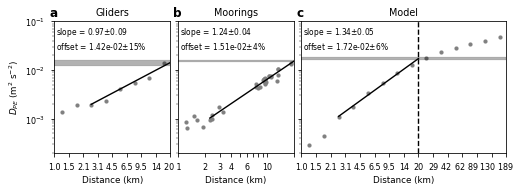

In [64]:
depth = 200;

fig = plt.figure(figsize=(7,2.5))
ww = .09; h = .73; hh=0.18; w1 = .23; w2 = w1*2.3/1.3; www = 0.015;
ax = (fig.add_axes([ww,hh,w1,h]), fig.add_axes([ww+w1+www,hh,w1,h]), fig.add_axes([ww+2*w1+www*2,hh,w2,h]))

x0 = np.array([bin_centers[2],20])
depind = np.argmin(np.abs(gl_sf_z-depth))
sf = np.nanmean((gl_nc.variables['D_2_b_timewindow'][:,depind,:,1].T/2/gl_b_z_sfs[:,depind].T).T,axis=0)
ax[0].scatter(np.log10(bin_centers),sf,s=15,color='0.5')
b0 = DISTANCE**(-gl_PE_fit_yr[0][depind])*gl_PE_fit_yr[2][depind]
ax[0].plot(np.log10(x0),b0*x0**gl_PE_fit_yr[0][depind],color='k')
ax[0].axhspan(gl_PE_fit_yr[2][depind]/gl_PE_fit_yr[3][depind],gl_PE_fit_yr[2][depind]*gl_PE_fit_yr[3][depind],color='k',alpha=0.3)
ax[0].set_xlim(np.log10(np.array([1,20])))
ax[0].set_xticks(np.log10(bin_edges))
ax[0].set_xticklabels(['1.0','1.5','2.1','3.1','4.5','6.5','9.5','14','20 ']);
ax[0].text(0.02,3e-2,'slope = %0.2f$\pm$%0.2f\noffset = %0.2e$\pm$%d%%'%(gl_PE_fit_yr[0][depind],gl_PE_fit_yr[1][depind],gl_PE_fit_yr[2][depind],(gl_PE_fit_yr[3][depind]-1)*100),fontsize=7.5)

x0 = np.array([np.sort(mr_sf_d)[5],20])
depind = np.argmin(np.abs(mr_z-depth))
sf = np.nanmean(mr_nc.variables['d_b'][:,depind]**2/2/mr_b_z_sfs[:,depind].T,axis=1)
ax[1].scatter(np.log10(mr_sf_d),sf,s=15,color='0.5')
b0 = DISTANCE**(-mr_PE_fit_yr[0][depind])*mr_PE_fit_yr[2][depind]
ax[1].plot(np.log10(x0),b0*x0**mr_PE_fit_yr[0][depind],color='k')
ax[1].axhspan(mr_PE_fit_yr[2][depind]/mr_PE_fit_yr[3][depind],mr_PE_fit_yr[2][depind]*mr_PE_fit_yr[3][depind],color='k',alpha=0.3)
ax[1].set_xlim(np.log10(np.array([1,20])))
ax[1].set_xticks(np.log10(np.array([1,2,3,4,5,6,7,8,9,10,20])))
ax[1].set_xticklabels([' 1','2','3','4',' ','6',' ',' ',' ','10',' '])
ax[1].text(0.02,3e-2,'slope = %0.2f$\pm$%0.2f\noffset = %0.2e$\pm$%d%%'%(mr_PE_fit_yr[0][depind],mr_PE_fit_yr[1][depind],mr_PE_fit_yr[2][depind],(mr_PE_fit_yr[3][depind]-1)*100),fontsize=7.5)

x0 = np.array([bin_centers_llc[2],20])
depind = np.argmin(np.abs(llc_z-depth))
sf = np.nanmean((llc_nc.variables['D_2_b'][:,depind].T/2/llc_b_z_sfs[:,depind].T).T,axis=0)
ax[2].scatter(np.log10(bin_centers_llc),sf,s=15,color='0.5')
b0 = DISTANCE**(-llc_PE_fit_yr[0][depind])*llc_PE_fit_yr[2][depind]
ax[2].plot(np.log10(x0),b0*x0**llc_PE_fit_yr[0][depind],color='k')
ax[2].axhspan(llc_PE_fit_yr[2][depind]/llc_PE_fit_yr[3][depind],llc_PE_fit_yr[2][depind]*llc_PE_fit_yr[3][depind],color='k',alpha=0.3)
ax[2].set_xlim(np.log10(np.array([1,189])));
ax[2].set_xticks(np.log10(bin_edges_llc))
ax[2].set_xticklabels(['1.0','1.5','2.1','3.1','4.5','6.5','9.5','14','20','29','42 ','62  ','89   ','130   ','189 ']);
ax[2].text(0.02,3e-2,'slope = %0.2f$\pm$%0.2f\noffset = %0.2e$\pm$%d%%'%(llc_PE_fit_yr[0][depind],llc_PE_fit_yr[1][depind],llc_PE_fit_yr[2][depind],(llc_PE_fit_yr[3][depind]-1)*100),fontsize=7.5)

for a in ax:
    a.set_yscale('log')
    a.set_ylim([2e-4,1e-1])
    a.set_xlabel('Distance (km)');
ax[2].axvline(np.log10(DISTANCE),color='k',ls='--')
for a in ax[1::]:
    a.set_yticklabels([])
ax[0].set_ylabel('$D_{PE}$ (m$^2$ s$^{-2}$)')

ax[0].set_title('Gliders'); ax[1].set_title('Moorings'); ax[2].set_title('Model');

# add panel labels
ax[0].annotate('a', xy=(0,1),xycoords=ax[0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1].annotate('b', xy=(0,1),xycoords=ax[1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2].annotate('c', xy=(0,1),xycoords=ax[2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('Fit_demo',dpi=300)

## Figure 10: Best-fits


In [116]:
mr_good_inds = np.arange(5,len(mr_z)-5)

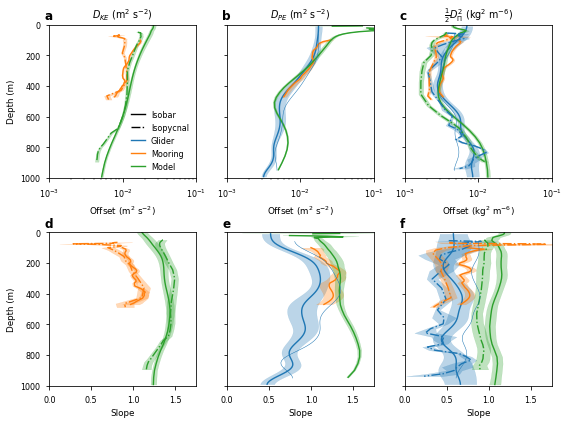

In [117]:
fig,ax = plt.subplots(2,3,figsize=(8,6))

ax[0,0].plot( mr_KE_fit_yr[2][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[0,0].plot(llc_KE_fit_yr[2],llc_z,color='C2')
ax[0,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_yr[2][mr_good_inds] / mr_KE_fit_yr[3][mr_good_inds], mr_KE_fit_yr[2][mr_good_inds] * mr_KE_fit_yr[3][mr_good_inds],color='C1',alpha=0.3)
ax[0,0].fill_betweenx(llc_z,llc_KE_fit_yr[2] /llc_KE_fit_yr[3],llc_KE_fit_yr[2] *llc_KE_fit_yr[3],color='C2',alpha=0.3)
ax[1,0].plot( mr_KE_fit_yr[0][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[1,0].plot(llc_KE_fit_yr[0],llc_z,color='C2')
ax[1,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_yr[0][mr_good_inds] - mr_KE_fit_yr[1][mr_good_inds], mr_KE_fit_yr[0][mr_good_inds] + mr_KE_fit_yr[1][mr_good_inds],color='C1',alpha=0.3)
ax[1,0].fill_betweenx(llc_z,llc_KE_fit_yr[0] -llc_KE_fit_yr[1],llc_KE_fit_yr[0] +llc_KE_fit_yr[1],color='C2',alpha=0.3)
ax[0,0].plot( mr_KE_fit_yr_ip[2], mr_z_ip_yr,color='C1',ls='-.')
ax[0,0].plot(llc_KE_fit_yr_ip[2],llc_z_ip_yr,color='C2',ls='-.')
ax[0,0].fill_betweenx( mr_z_ip_yr, mr_KE_fit_yr_ip[2] / mr_KE_fit_yr_ip[3], mr_KE_fit_yr_ip[2] * mr_KE_fit_yr_ip[3],color='C1',alpha=0.3)
ax[0,0].fill_betweenx(llc_z_ip_yr,llc_KE_fit_yr_ip[2] /llc_KE_fit_yr_ip[3],llc_KE_fit_yr_ip[2] *llc_KE_fit_yr_ip[3],color='C2',alpha=0.3)
ax[1,0].plot( mr_KE_fit_yr_ip[0], mr_z_ip_yr,color='C1',ls='-.')
ax[1,0].plot(llc_KE_fit_yr_ip[0],llc_z_ip_yr,color='C2',ls='-.')
ax[1,0].fill_betweenx( mr_z_ip_yr, mr_KE_fit_yr_ip[0] - mr_KE_fit_yr_ip[1], mr_KE_fit_yr_ip[0] + mr_KE_fit_yr_ip[1],color='C1',alpha=0.3)
ax[1,0].fill_betweenx(llc_z_ip_yr,llc_KE_fit_yr_ip[0] -llc_KE_fit_yr_ip[1],llc_KE_fit_yr_ip[0] +llc_KE_fit_yr_ip[1],color='C2',alpha=0.3)


ax[0,1].plot( gl_PE_fit_yr[2], gl_sf_z,color='C0')
ax[0,1].plot( mr_PE_fit_yr[2][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[0,1].plot(llc_PE_fit_yr[2],llc_z,color='C2')
ax[0,1].fill_betweenx( gl_sf_z, gl_PE_fit_yr[2] / gl_PE_fit_yr[3], gl_PE_fit_yr[2] * gl_PE_fit_yr[3],color='C0',alpha=0.3)
ax[0,1].fill_betweenx( mr_z[mr_good_inds], mr_PE_fit_yr[2][mr_good_inds] / mr_PE_fit_yr[3][mr_good_inds], mr_PE_fit_yr[2][mr_good_inds] * mr_PE_fit_yr[3][mr_good_inds],color='C1',alpha=0.3)
ax[0,1].fill_betweenx(llc_z,llc_PE_fit_yr[2] /llc_PE_fit_yr[3],llc_PE_fit_yr[2] *llc_PE_fit_yr[3],color='C2',alpha=0.3)
ax[1,1].plot( gl_PE_fit_yr[0], gl_sf_z,color='C0')
ax[1,1].plot( mr_PE_fit_yr[0][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[1,1].plot(llc_PE_fit_yr[0],llc_z,color='C2')
ax[1,1].fill_betweenx( gl_sf_z, gl_PE_fit_yr[0] - gl_PE_fit_yr[1], gl_PE_fit_yr[0] + gl_PE_fit_yr[1],color='C0',alpha=0.3)
ax[1,1].fill_betweenx( mr_z[mr_good_inds], mr_PE_fit_yr[0][mr_good_inds] - mr_PE_fit_yr[1][mr_good_inds], mr_PE_fit_yr[0][mr_good_inds] + mr_PE_fit_yr[1][mr_good_inds],color='C1',alpha=0.3)
ax[1,1].fill_betweenx(llc_z,llc_PE_fit_yr[0] -llc_PE_fit_yr[1],llc_PE_fit_yr[0] +llc_PE_fit_yr[1],color='C2',alpha=0.3)

ax[0,2].plot( gl_sp_fit_yr[2], gl_sf_z,color='C0')
ax[0,2].plot( mr_sp_fit_yr[2][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[0,2].plot(llc_sp_fit_yr[2],llc_z,color='C2')
ax[0,2].fill_betweenx( gl_sf_z, gl_sp_fit_yr[2] / gl_sp_fit_yr[3], gl_sp_fit_yr[2] * gl_sp_fit_yr[3],color='C0',alpha=0.3)
ax[0,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_yr[2][mr_good_inds] / mr_sp_fit_yr[3][mr_good_inds], mr_sp_fit_yr[2][mr_good_inds] * mr_sp_fit_yr[3][mr_good_inds],color='C1',alpha=0.3)
ax[0,2].fill_betweenx(llc_z,llc_sp_fit_yr[2] /llc_sp_fit_yr[3],llc_sp_fit_yr[2] *llc_sp_fit_yr[3],color='C2',alpha=0.3)
ax[1,2].plot( gl_sp_fit_yr[0], gl_sf_z,color='C0')
ax[1,2].plot( mr_sp_fit_yr[0][mr_good_inds], mr_z[mr_good_inds],color='C1')
ax[1,2].plot(llc_sp_fit_yr[0],llc_z,color='C2')
ax[1,2].fill_betweenx( gl_sf_z, gl_sp_fit_yr[0] - gl_sp_fit_yr[1], gl_sp_fit_yr[0] + gl_sp_fit_yr[1],color='C0',alpha=0.3)
ax[1,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_yr[0][mr_good_inds] - mr_sp_fit_yr[1][mr_good_inds], mr_sp_fit_yr[0][mr_good_inds] + mr_sp_fit_yr[1][mr_good_inds],color='C1',alpha=0.3)
ax[1,2].fill_betweenx(llc_z,llc_sp_fit_yr[0] -llc_sp_fit_yr[1],llc_sp_fit_yr[0] +llc_sp_fit_yr[1],color='C2',alpha=0.3)
ax[0,2].plot( gl_sp_fit_yr_ip[2], gl_z_ip_yr,color='C0',ls='-.')
ax[0,2].plot( mr_sp_fit_yr_ip[2], mr_z_ip_yr,color='C1',ls='-.')
ax[0,2].plot(llc_sp_fit_yr_ip[2],llc_z_ip_yr,color='C2',ls='-.')
ax[0,2].fill_betweenx( gl_z_ip_yr, gl_sp_fit_yr_ip[2] / gl_sp_fit_yr_ip[3], gl_sp_fit_yr_ip[2] * gl_sp_fit_yr_ip[3],color='C0',alpha=0.3)
ax[0,2].fill_betweenx( mr_z_ip_yr, mr_sp_fit_yr_ip[2] / mr_sp_fit_yr_ip[3], mr_sp_fit_yr_ip[2] * mr_sp_fit_yr_ip[3],color='C1',alpha=0.3)
ax[0,2].fill_betweenx(llc_z_ip_yr,llc_sp_fit_yr_ip[2] /llc_sp_fit_yr_ip[3],llc_sp_fit_yr_ip[2] *llc_sp_fit_yr_ip[3],color='C2',alpha=0.3)
ax[1,2].plot( gl_sp_fit_yr_ip[0], gl_z_ip_yr,color='C0',ls='-.')
ax[1,2].plot( mr_sp_fit_yr_ip[0], mr_z_ip_yr,color='C1',ls='-.')
ax[1,2].plot(llc_sp_fit_yr_ip[0],llc_z_ip_yr,color='C2',ls='-.')
ax[1,2].fill_betweenx( gl_z_ip_yr, gl_sp_fit_yr_ip[0] - gl_sp_fit_yr_ip[1], gl_sp_fit_yr_ip[0] + gl_sp_fit_yr_ip[1],color='C0',alpha=0.3)
ax[1,2].fill_betweenx( mr_z_ip_yr, mr_sp_fit_yr_ip[0] - mr_sp_fit_yr_ip[1], mr_sp_fit_yr_ip[0] + mr_sp_fit_yr_ip[1],color='C1',alpha=0.3)
ax[1,2].fill_betweenx(llc_z_ip_yr,llc_sp_fit_yr_ip[0] -llc_sp_fit_yr_ip[1],llc_sp_fit_yr_ip[0] +llc_sp_fit_yr_ip[1],color='C2',alpha=0.3)

ax[0,1].plot( gl_av_PE_fit_yr[2], gl_sf_z[5:-4], color='C0', lw=0.5)
ax[1,1].plot( gl_av_PE_fit_yr[0], gl_sf_z[5:-4], color='C0', lw=0.5)
ax[0,2].plot( gl_av_sp_fit_yr[2], gl_sf_z[5:-4], color='C0', lw=0.5)
ax[1,2].plot( gl_av_sp_fit_yr[0], gl_sf_z[5:-4], color='C0', lw=0.5)


l1, = ax[0,0].plot([],[],color='k',ls='-')
l2, = ax[0,0].plot([],[],color='k',ls='-.')
l3, = ax[0,0].plot([],[],color='C0',ls='-')
l4, = ax[0,0].plot([],[],color='C1',ls='-')
l5, = ax[0,0].plot([],[],color='C2',ls='-')
ax[0,0].legend([l1,l2,l3,l4,l5],['Isobar','Isopycnal','Glider','Mooring','Model'],loc='lower right',frameon=False,handlelength=1.75)

for a in ax.ravel():
    a.set_ylim([1000,0])
for a in ax[1]:
    a.set_xlim([0,1.75]); a.set_xticks(np.arange(0,1.75,.5)); a.set_xlabel('Slope');
for a in ax[0]:
    a.set_xscale('log'); a.set_xlim([1e-3,1e-1]);
for a in ax[:,1::].ravel():
    a.set_yticklabels([]);
for a in ax[:,0]:
    a.set_ylabel('Depth (m)')
ax[0,0].set_title('$D_{KE}$ (m$^2$ s$^{-2}$)'); ax[0,0].set_xlabel('Offset (m$^2$ s$^{-2}$)');
ax[0,1].set_title('$D_{PE}$ (m$^2$ s$^{-2}$)'); ax[0,1].set_xlabel('Offset (m$^2$ s$^{-2}$)');
ax[0,2].set_title(r'$\frac{1}{2}D_\Pi^2$ (kg$^2$ m$^{-6}$)'); ax[0,2].set_xlabel('Offset (kg$^2$ m$^{-6}$)');

plt.tight_layout();

# add panel labels
labels = ('a','b','c','d','e','f')
for iii in range(len(ax.ravel())):
    ax.ravel()[iii].annotate(labels[iii], xy=(0,1),xycoords=ax.ravel()[iii].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('Slopes',dpi=300)

## Figure 11: Best-fits seasonal

In [30]:
mr_good_inds = np.arange(5,len(mr_z)-5)

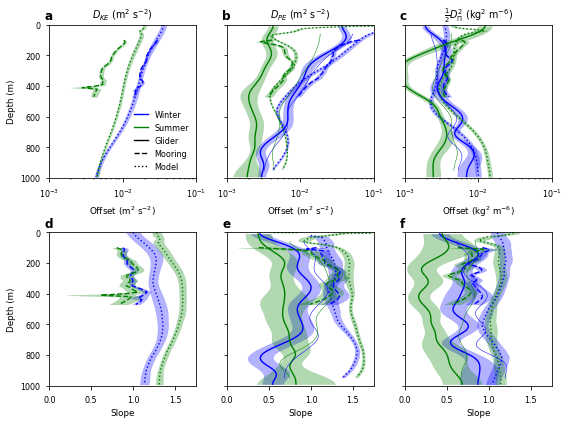

In [31]:
fig,ax = plt.subplots(2,3,figsize=(8,6))

ax[0,0].plot( mr_KE_fit_w[2][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[0,0].plot(llc_KE_fit_w[2],llc_z,color=winter_color, ls=':')
ax[0,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_w[2][mr_good_inds] / mr_KE_fit_w[3][mr_good_inds], mr_KE_fit_w[2][mr_good_inds] * mr_KE_fit_w[3][mr_good_inds],color=winter_color,alpha=0.3)
ax[0,0].fill_betweenx(llc_z,llc_KE_fit_w[2] /llc_KE_fit_w[3],llc_KE_fit_w[2] *llc_KE_fit_w[3],color=winter_color,alpha=0.3)
ax[1,0].plot( mr_KE_fit_w[0][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[1,0].plot(llc_KE_fit_w[0],llc_z,color=winter_color, ls=':')
ax[1,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_w[0][mr_good_inds] - mr_KE_fit_w[1][mr_good_inds], mr_KE_fit_w[0][mr_good_inds] + mr_KE_fit_w[1][mr_good_inds],color=winter_color,alpha=0.3)
ax[1,0].fill_betweenx(llc_z,llc_KE_fit_w[0] -llc_KE_fit_w[1],llc_KE_fit_w[0] +llc_KE_fit_w[1],color=winter_color,alpha=0.3)
ax[0,0].plot( mr_KE_fit_s[2][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[0,0].plot(llc_KE_fit_s[2],llc_z,color=summer_color, ls=':')
ax[0,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_s[2][mr_good_inds] / mr_KE_fit_s[3][mr_good_inds], mr_KE_fit_s[2][mr_good_inds] * mr_KE_fit_s[3][mr_good_inds],color=summer_color,alpha=0.3)
ax[0,0].fill_betweenx(llc_z,llc_KE_fit_s[2] /llc_KE_fit_s[3],llc_KE_fit_s[2] *llc_KE_fit_s[3],color=summer_color,alpha=0.3)
ax[1,0].plot( mr_KE_fit_s[0][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[1,0].plot(llc_KE_fit_s[0],llc_z,color=summer_color, ls=':')
ax[1,0].fill_betweenx( mr_z[mr_good_inds], mr_KE_fit_s[0][mr_good_inds] - mr_KE_fit_s[1][mr_good_inds], mr_KE_fit_s[0][mr_good_inds] + mr_KE_fit_s[1][mr_good_inds],color=summer_color,alpha=0.3)
ax[1,0].fill_betweenx(llc_z,llc_KE_fit_s[0] -llc_KE_fit_s[1],llc_KE_fit_s[0] +llc_KE_fit_s[1],color=summer_color,alpha=0.3)

ax[0,1].plot( gl_PE_fit_w[2], gl_sf_z,color=winter_color, ls='-')
ax[0,1].plot( mr_PE_fit_w[2][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[0,1].plot(llc_PE_fit_w[2],llc_z,color=winter_color, ls=':')
ax[0,1].fill_betweenx(gl_sf_z, gl_PE_fit_w[2] / gl_PE_fit_w[3], gl_PE_fit_w[2] * gl_PE_fit_w[3],color=winter_color,alpha=0.3)
ax[0,1].fill_betweenx(   mr_z[mr_good_inds], mr_PE_fit_w[2][mr_good_inds] / mr_PE_fit_w[3][mr_good_inds], mr_PE_fit_w[2][mr_good_inds] * mr_PE_fit_w[3][mr_good_inds],color=winter_color,alpha=0.3)
ax[0,1].fill_betweenx(  llc_z,llc_PE_fit_w[2] /llc_PE_fit_w[3],llc_PE_fit_w[2] *llc_PE_fit_w[3],color=winter_color,alpha=0.3)
ax[1,1].plot( gl_PE_fit_w[0], gl_sf_z,color=winter_color, ls='-')
ax[1,1].plot( mr_PE_fit_w[0][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[1,1].plot(llc_PE_fit_w[0],llc_z,color=winter_color, ls=':')
ax[1,1].fill_betweenx( gl_sf_z, gl_PE_fit_w[0] - gl_PE_fit_w[1], gl_PE_fit_w[0] + gl_PE_fit_w[1],color=winter_color,alpha=0.3)
ax[1,1].fill_betweenx( mr_z[mr_good_inds], mr_PE_fit_w[0][mr_good_inds] - mr_PE_fit_w[1][mr_good_inds], mr_PE_fit_w[0][mr_good_inds] + mr_PE_fit_w[1][mr_good_inds],color=winter_color,alpha=0.3)
ax[1,1].fill_betweenx(llc_z,llc_PE_fit_w[0] -llc_PE_fit_w[1],llc_PE_fit_w[0] +llc_PE_fit_w[1],color=winter_color,alpha=0.3)
ax[0,1].plot( gl_PE_fit_s[2], gl_sf_z,color=summer_color, ls='-')
ax[0,1].plot( mr_PE_fit_s[2][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[0,1].plot(llc_PE_fit_s[2],llc_z,color=summer_color, ls=':')
ax[0,1].fill_betweenx(gl_sf_z, gl_PE_fit_s[2] / gl_PE_fit_s[3], gl_PE_fit_s[2] * gl_PE_fit_s[3],color=summer_color,alpha=0.3)
ax[0,1].fill_betweenx(   mr_z[mr_good_inds], mr_PE_fit_s[2][mr_good_inds] / mr_PE_fit_s[3][mr_good_inds], mr_PE_fit_s[2][mr_good_inds] * mr_PE_fit_s[3][mr_good_inds],color=summer_color,alpha=0.3)
ax[0,1].fill_betweenx(  llc_z,llc_PE_fit_s[2] /llc_PE_fit_s[3],llc_PE_fit_s[2] *llc_PE_fit_s[3],color=summer_color,alpha=0.3)
ax[1,1].plot( gl_PE_fit_s[0], gl_sf_z,color=summer_color, ls='-')
ax[1,1].plot( mr_PE_fit_s[0][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[1,1].plot(llc_PE_fit_s[0],llc_z,color=summer_color, ls=':')
ax[1,1].fill_betweenx( gl_sf_z, gl_PE_fit_s[0] - gl_PE_fit_s[1], gl_PE_fit_s[0] + gl_PE_fit_s[1],color=summer_color,alpha=0.3)
ax[1,1].fill_betweenx( mr_z[mr_good_inds], mr_PE_fit_s[0][mr_good_inds] - mr_PE_fit_s[1][mr_good_inds], mr_PE_fit_s[0][mr_good_inds] + mr_PE_fit_s[1][mr_good_inds],color=summer_color,alpha=0.3)
ax[1,1].fill_betweenx(llc_z,llc_PE_fit_s[0] -llc_PE_fit_s[1],llc_PE_fit_s[0] +llc_PE_fit_s[1],color=summer_color,alpha=0.3)

ax[0,2].plot( gl_sp_fit_w[2], gl_sf_z,color=winter_color, ls='-')
ax[0,2].plot( mr_sp_fit_w[2][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[0,2].plot(llc_sp_fit_w[2],llc_z,color=winter_color, ls=':')
ax[0,2].fill_betweenx( gl_sf_z, gl_sp_fit_w[2] / gl_sp_fit_w[3], gl_sp_fit_w[2] * gl_sp_fit_w[3],color=winter_color,alpha=0.3)
ax[0,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_w[2][mr_good_inds] / mr_sp_fit_w[3][mr_good_inds], mr_sp_fit_w[2][mr_good_inds] * mr_sp_fit_w[3][mr_good_inds],color=winter_color,alpha=0.3)
ax[0,2].fill_betweenx(llc_z,llc_sp_fit_w[2] /llc_sp_fit_w[3],llc_sp_fit_w[2] *llc_sp_fit_w[3],color=winter_color,alpha=0.3)
ax[1,2].plot( gl_sp_fit_w[0], gl_sf_z,color=winter_color, ls='-')
ax[1,2].plot( mr_sp_fit_w[0][mr_good_inds], mr_z[mr_good_inds],color=winter_color, ls='--')
ax[1,2].plot(llc_sp_fit_w[0],llc_z,color=winter_color, ls=':')
ax[1,2].fill_betweenx( gl_sf_z, gl_sp_fit_w[0] - gl_sp_fit_w[1], gl_sp_fit_w[0] + gl_sp_fit_w[1],color=winter_color,alpha=0.3)
ax[1,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_w[0][mr_good_inds] - mr_sp_fit_w[1][mr_good_inds], mr_sp_fit_w[0][mr_good_inds] + mr_sp_fit_w[1][mr_good_inds],color=winter_color,alpha=0.3)
ax[1,2].fill_betweenx(llc_z,llc_sp_fit_w[0] -llc_sp_fit_w[1],llc_sp_fit_w[0] +llc_sp_fit_w[1],color=winter_color,alpha=0.3)
ax[0,2].plot( gl_sp_fit_s[2], gl_sf_z,color=summer_color, ls='-')
ax[0,2].plot( mr_sp_fit_s[2][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[0,2].plot(llc_sp_fit_s[2],llc_z,color=summer_color, ls=':')
ax[0,2].fill_betweenx( gl_sf_z, gl_sp_fit_s[2] / gl_sp_fit_s[3], gl_sp_fit_s[2] * gl_sp_fit_s[3],color=summer_color,alpha=0.3)
ax[0,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_s[2][mr_good_inds] / mr_sp_fit_s[3][mr_good_inds], mr_sp_fit_s[2][mr_good_inds] * mr_sp_fit_s[3][mr_good_inds],color=summer_color,alpha=0.3)
ax[0,2].fill_betweenx(llc_z,llc_sp_fit_s[2] /llc_sp_fit_s[3],llc_sp_fit_s[2] *llc_sp_fit_s[3],color=summer_color,alpha=0.3)
ax[1,2].plot( gl_sp_fit_s[0], gl_sf_z,color=summer_color, ls='-')
ax[1,2].plot( mr_sp_fit_s[0][mr_good_inds], mr_z[mr_good_inds],color=summer_color, ls='--')
ax[1,2].plot(llc_sp_fit_s[0],llc_z,color=summer_color, ls=':')
ax[1,2].fill_betweenx( gl_sf_z, gl_sp_fit_s[0] - gl_sp_fit_s[1], gl_sp_fit_s[0] + gl_sp_fit_s[1],color=summer_color,alpha=0.3)
ax[1,2].fill_betweenx( mr_z[mr_good_inds], mr_sp_fit_s[0][mr_good_inds] - mr_sp_fit_s[1][mr_good_inds], mr_sp_fit_s[0][mr_good_inds] + mr_sp_fit_s[1][mr_good_inds],color=summer_color,alpha=0.3)
ax[1,2].fill_betweenx(llc_z,llc_sp_fit_s[0] -llc_sp_fit_s[1],llc_sp_fit_s[0] +llc_sp_fit_s[1],color=summer_color,alpha=0.3)

ax[0,1].plot( gl_av_PE_fit_w[2], gl_sf_z[5:-4], color=winter_color, lw=0.5)
ax[1,1].plot( gl_av_PE_fit_w[0], gl_sf_z[5:-4], color=winter_color, lw=0.5)
ax[0,2].plot( gl_av_sp_fit_w[2], gl_sf_z[5:-4], color=winter_color, lw=0.5)
ax[1,2].plot( gl_av_sp_fit_w[0], gl_sf_z[5:-4], color=winter_color, lw=0.5)
ax[0,1].plot( gl_av_PE_fit_s[2], gl_sf_z[5:-4], color=summer_color, lw=0.5)
ax[1,1].plot( gl_av_PE_fit_s[0], gl_sf_z[5:-4], color=summer_color, lw=0.5)
ax[0,2].plot( gl_av_sp_fit_s[2], gl_sf_z[5:-4], color=summer_color, lw=0.5)
ax[1,2].plot( gl_av_sp_fit_s[0], gl_sf_z[5:-4], color=summer_color, lw=0.5)

l1, = ax[0,0].plot([],[],color=winter_color,ls='-')
l2, = ax[0,0].plot([],[],color=summer_color,ls='-')
l3, = ax[0,0].plot([],[],color='k',ls='-')
l4, = ax[0,0].plot([],[],color='k',ls='--')
l5, = ax[0,0].plot([],[],color='k',ls=':')
ax[0,0].legend([l1,l2,l3,l4,l5],['Winter','Summer','Glider','Mooring','Model'],loc='lower right',frameon=False,handlelength=1.75)

for a in ax.ravel():
    a.set_ylim([1000,0])
for a in ax[1]:
    a.set_xlim([0,1.75]); a.set_xticks(np.arange(0,1.75,.5)); a.set_xlabel('Slope');
for a in ax[0]:
    a.set_xscale('log'); a.set_xlim([1e-3,1e-1]);
for a in ax[:,1::].ravel():
    a.set_yticklabels([]);
for a in ax[:,0]:
    a.set_ylabel('Depth (m)')
ax[0,0].set_title('$D_{KE}$ (m$^2$ s$^{-2}$)'); ax[0,0].set_xlabel('Offset (m$^2$ s$^{-2}$)');
ax[0,1].set_title('$D_{PE}$ (m$^2$ s$^{-2}$)'); ax[0,1].set_xlabel('Offset (m$^2$ s$^{-2}$)');
ax[0,2].set_title(r'$\frac{1}{2}D_\Pi^2$ (kg$^2$ m$^{-6}$)'); ax[0,2].set_xlabel('Offset (kg$^2$ m$^{-6}$)');

#n = np.sqrt(1e-5); k = 1/(20*1000); m = k*n/f;
#ax[0,0].plot([3e-2,3e-2/np.e],[200,200+1/m],color='0.75')
#ax[0,1].plot([3e-2,3e-2/np.e],[200,200+1/m],color='0.75')

plt.tight_layout();

# add panel labels
labels = ('a','b','c','d','e','f')
for iii in range(len(ax.ravel())):
    ax.ravel()[iii].annotate(labels[iii], xy=(0,1),xycoords=ax.ravel()[iii].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('Slopes_seasons',dpi=300)

## Figure 12: Offsets

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


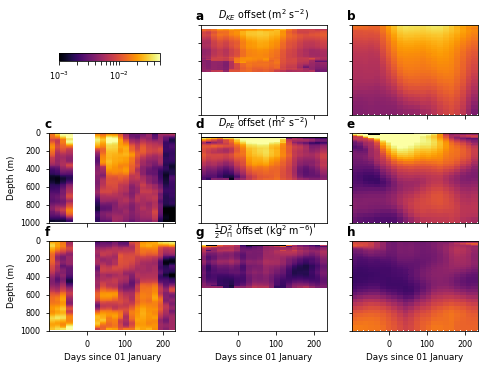

In [27]:
time_edges = np.arange(gl_nc.variables['time_window'][0]-7.5,gl_nc.variables['time_window'][-1]+15,15)
fig,ax = plt.subplots(3,3,figsize=(7,5))
vmin=1e-3; vmax=5e-2;
ax[0,1].pcolormesh(time_edges,mr_z,mr_KE_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
im = ax[0,2].pcolormesh(time_edges,llc_z,llc_KE_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,0].pcolormesh(time_edges,gl_sf_z,np.ma.masked_invalid(gl_PE_offsets_all),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,1].pcolormesh(time_edges,mr_z,mr_PE_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,2].pcolormesh(time_edges,llc_z,llc_PE_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[2,0].pcolormesh(time_edges,gl_sf_z,np.ma.masked_invalid(gl_sp_offsets_all),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[2,1].pcolormesh(time_edges,mr_z,mr_sp_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[2,2].pcolormesh(time_edges,llc_z,llc_sp_offsets_all,norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)

for a in ax.ravel():
    a.set_ylim([1000,0])
for a in ax[:,1::].ravel():
    a.set_yticklabels([])
for a in ax[0:-1,:].ravel():
    a.set_xticklabels([])
for a in ax[2]:
    a.set_xlabel('Days since 01 January')
for a in ax[:,0]:
    a.set_ylabel('Depth (m)')
ax[0,0].set_visible(False)

ax[2,1].set_title(r'$\frac{1}{2}D_\Pi^2$ offset (kg$^2$ m$^{-6}$)')
ax[1,1].set_title('$D_{PE}$ offset (m$^2$ s$^{-2}$)')
ax[0,1].set_title('$D_{KE}$ offset (m$^2$ s$^{-2}$)')

plt.subplots_adjust(left=0.1,right=0.95,top=0.95,bottom=0.1)

cax = fig.add_axes([.12,.85,.2,.02])
plt.colorbar(im,cax=cax,orientation='horizontal')#,ticks=np.arange(0,.021,.01))

# add panel labels
ax[0,1].annotate('a', xy=(0,1),xycoords=ax[0,1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[0,2].annotate('b', xy=(0,1),xycoords=ax[0,2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,0].annotate('c', xy=(0,1),xycoords=ax[1,0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,1].annotate('d', xy=(0,1),xycoords=ax[1,1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,2].annotate('e', xy=(0,1),xycoords=ax[1,2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2,0].annotate('f', xy=(0,1),xycoords=ax[2,0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2,1].annotate('g', xy=(0,1),xycoords=ax[2,1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[2,2].annotate('h', xy=(0,1),xycoords=ax[2,2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('grid_offsets1',dpi=300)

## Figure 13: Offsets (isopycnals)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


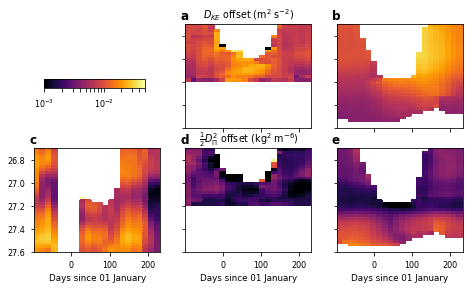

In [29]:
fig,ax = plt.subplots(2,3,figsize=(7,4))
vmin=1e-3; vmax=5e-2;

ax[0,1].pcolormesh(time_edges,mr_nc.variables['isopycnal'][:],np.ma.masked_invalid(mr_KE_offsets_all_ip),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
im = ax[0,2].pcolormesh(time_edges,llc_nc.variables['isopycnal'][:],np.ma.masked_invalid(llc_KE_offsets_all_ip),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,0].pcolormesh(time_edges,gl_nc.variables['isopycnal'][:],np.ma.masked_invalid(gl_sp_offsets_all_ip),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,1].pcolormesh(time_edges,mr_nc.variables['isopycnal'][:],np.ma.masked_invalid(mr_sp_offsets_all_ip),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)
ax[1,2].pcolormesh(time_edges,llc_nc.variables['isopycnal'][:],np.ma.masked_invalid(llc_sp_offsets_all_ip),norm=pltcolors.LogNorm(vmin=vmin,vmax=vmax),cmap=plt.cm.inferno)

for a in ax.ravel():
    a.set_ylim([27.6,26.7])
for a in ax[:,1::].ravel():
    a.set_yticklabels([])
for a in ax[0]:
    a.set_xticklabels([])
for a in ax[1]:
    a.set_xlabel('Days since 01 January')
ax[0,0].set_visible(False)

ax[1,1].set_title(r'$\frac{1}{2}D_\Pi^2$ offset (kg$^2$ m$^{-6}$)')
ax[0,1].set_title('$D_{KE}$ offset (m$^2$ s$^{-2}$)')

plt.subplots_adjust(left=0.1,right=0.95,top=0.92,bottom=0.13)

cax = fig.add_axes([.12,.7,.2,.03])
plt.colorbar(im,cax=cax,orientation='horizontal')#,ticks=np.arange(0,0.021,.01))

# add panel labels
ax[0,1].annotate('a', xy=(0,1),xycoords=ax[0,1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[0,2].annotate('b', xy=(0,1),xycoords=ax[0,2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,0].annotate('c', xy=(0,1),xycoords=ax[1,0].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,1].annotate('d', xy=(0,1),xycoords=ax[1,1].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")
ax[1,2].annotate('e', xy=(0,1),xycoords=ax[1,2].transAxes,color='k',weight='bold',size=fontsize,xytext=(-5,5), textcoords="offset points")

plt.savefig('grid_offsets2',dpi=300)

## Figure A1: Separation uncertainty

In [153]:
deps = np.arange(10,1000,10)
dist = ();
for j in range(len(SG)):
    print(SG[j])
    d = np.nan*np.empty(shape=(nc_SG_L2[j].variables['time'].shape[0],len(deps)))
    for i in range(nc_SG_L1[j].variables['time'].shape[0]):
        notnan = ~np.isnan(nc_SG_L1[j].variables['pressure'][i])
        maxdepind = np.argmax(nc_SG_L1[j].variables['pressure'][i][notnan])
        lat_fm = np.interp(deps,nc_SG_L1[j].variables['pressure'][i,notnan][0:maxdepind],nc_SG_L1[j].variables['latitude'][i,notnan][0:maxdepind])
        lon_fm = np.interp(deps,nc_SG_L1[j].variables['pressure'][i,notnan][0:maxdepind],nc_SG_L1[j].variables['longitude'][i,notnan][0:maxdepind])
        lat_ln = np.interp(deps,nc_SG_L2[j].variables['pressure'][:],nc_SG_L2[j].variables['latitude'][i*2])
        lon_ln = np.interp(deps,nc_SG_L2[j].variables['pressure'][:],nc_SG_L2[j].variables['longitude'][i*2])
        d[i*2] = np.sqrt(((lat_ln-lat_fm)*LAT_DEGREE_TO_KM)**2+((lon_ln-lon_fm)*LON_DEGREE_TO_KM)**2)
        lat_fm = np.interp(deps,nc_SG_L1[j].variables['pressure'][i,notnan][maxdepind::],nc_SG_L1[j].variables['latitude'][i,notnan][maxdepind::])
        lon_fm = np.interp(deps,nc_SG_L1[j].variables['pressure'][i,notnan][maxdepind::],nc_SG_L1[j].variables['longitude'][i,notnan][maxdepind::])
        lat_ln = np.interp(deps,nc_SG_L2[j].variables['pressure'][:],nc_SG_L2[j].variables['latitude'][i*2+1])
        lon_ln = np.interp(deps,nc_SG_L2[j].variables['pressure'][:],nc_SG_L2[j].variables['longitude'][i*2+1])
        d[i*2+1] = np.sqrt(((lat_ln-lat_fm)*LAT_DEGREE_TO_KM)**2+((lon_ln-lon_fm)*LON_DEGREE_TO_KM)**2)
    dist += (d,)


sg502_JanApr


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: Ru

sg510_AprSep
sg533_AprSep
sg533_SepJan
sg566_AprSep
sg566_SepJan
sg579_JanApr


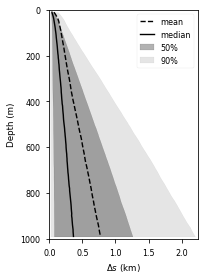

In [163]:
fig = plt.figure(figsize=(3,4))
plt.plot(np.nanmean(np.concatenate(dist),axis=0),deps,color='k',ls='--')
plt.plot(np.nanmedian(np.concatenate(dist),axis=0),deps,color='k')
plt.fill_betweenx(deps,np.nanpercentile(np.concatenate(dist),25,axis=0),np.nanpercentile(np.concatenate(dist),75,axis=0),alpha=0.3,color='k')
plt.fill_betweenx(deps,np.nanpercentile(np.concatenate(dist),5,axis=0),np.nanpercentile(np.concatenate(dist),95,axis=0),alpha=0.1,color='k')
plt.ylim([1000,0]); plt.xlim([0,2.25])
plt.xlabel('$\Delta s$ (km)')
plt.ylabel('Depth (m)')
plt.legend(['mean','median','50%','90%'],handlelength=1.75)
plt.tight_layout()
plt.savefig('Sep_uncert',dpi=300)


## Figure A2: Mean separation

In [164]:
t_gl = np.concatenate([nc.variables['time'][:] for nc in nc_SG_L2])
lat_gl = np.concatenate([nc.variables['latitude'][:] for nc in nc_SG_L2])
lon_gl = np.concatenate([nc.variables['longitude'][:] for nc in nc_SG_L2])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
